## Data Visualizations for Textual Data

## libraries

In [1]:
import numpy as np
import pandas as pd

import json
import datetime
from datetime import datetime

import re
import os
import glob

from textblob import TextBlob

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter

import statsmodels.api as sm

import gensim

import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import spacy
import pyLDAvis
import pyLDAvis.gensim


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## data import

In [2]:
### loading the data


## Inferred Tweets and Exxon/IPCC data

# this data has climate-related labels as inferred by the climateBERT model
# it is used to analyse sentiment within the text as well as sentence structure / length

exxon_data = pd.read_csv("inference/exxon_data_infered.csv", index_col= 0)
exxon_paragraphs_data = pd.read_csv("exxon_paragraphs_out.csv", index_col= 0)
ipcc_data = pd.read_csv("inference/ipcc_data_infered.csv", index_col= 0)

downplaying_tweets_data = pd.read_csv("inference/downplaying_tweets_data_infered.csv", index_col= 0)
underscoring_tweets_data = pd.read_csv("inference/underscoring_tweets_data_infered.csv", index_col= 0)


# main dataset of US, UK & Australian politicians (climate and downplaying label inferred)
politicians_us_data = pd.read_parquet("inference/climate_influencers_inference/us_politicians_infered.parquet")
politicians_us_data.drop(columns="downplaying_pred", inplace=True)
politicians_us_data.rename(columns={"downplaying_pred_second_run":"downplaying_pred"}, inplace=True)

politicians_australia_data = pd.read_parquet("inference/climate_influencers_inference/australian_politicians_infered.parquet")
politicians_uk_data = pd.read_parquet("inference/climate_influencers_inference/uk_politicians_infered.parquet")

# dataset with Trump, Obama, Al Gore and other selected politicians
# (full timeline)
politicians_with_trump_tweets_data = pd.read_parquet("inference/climate_influencers_inference/selected_politicians_infered.parquet")
politicians_with_trump_tweets_data = politicians_with_trump_tweets_data.iloc[:,2:]
politicians_with_trump_tweets_data.rename(columns={'author.name' : 'name'}, inplace = True)


## Scores from League of Conservation Voters (LCV)
politicians_LCV_scores = pd.read_csv("model_evaluation/politicians_LCV_scores_final.csv", 
                                    sep = ";", 
                                    encoding='ISO-8859-1', 
                                    index_col= False, 
                                    usecols= ['politician','LCV_lifetime_score', 'Source_LCV'])

In [3]:
ipcc_data.groupby("climate_related_pred").count()

,Unnamed: 0,original_text,cleaned_text,climate-related,downplaying,source,type,year,tok_length,predictions
climate_related_pred,,,,,,,,,,
0,1463,1459,1463,1463,1463,1463,1463,1463,1463,1463
1,2036,2028,2036,2036,2036,2036,2036,2036,2036,2036


In [4]:
wynes_2022_politician_data = pd.read_parquet("Wynes_2022/politicians_wynes_2022.parquet")
wynes_2022_politician_data['name_lowered'] = wynes_2022_politician_data['name'].str.lower()
wynes_mapping = pd.read_csv("vanVliet_to_wynes_mapping.txt", sep="\t",encoding ="ISO-8859-1")

In [5]:
# additional timeseries and politician specific variables

cop_dates = pd.read_csv("C:/Users/lucas/Desktop/Bachelor Arbeit/new_python/panel_regression/COP_dates.csv", sep = ";")

us_politicians_region = pd.read_csv("./panel_regression/region_mapping.csv", sep = ";")
us_politicians_birthyear = pd.read_csv("./panel_regression/age_mapping_us_politicians.txt", sep = "\t", encoding="ISO-8859-1")

follower_count_selected_politicians = pd.read_csv("./follower_timeseries/followers_timeseries_selected_pol.csv", sep = ";")

us_politicians_follower_count = pd.read_csv("./follower_timeseries/followers_timeseries_us_pol.csv")
uk_politicians_follower_count = pd.read_csv("./follower_timeseries/followers_timeseries_uk_pol.csv")
australia_politicians_follower_count = pd.read_csv("./follower_timeseries/followers_timeseries_australia_pol.csv")

## functions

In [6]:
# remove middle name from politicians

def remove_middle_name(input_name):
    name_no_middle = re.sub(' [A-Za-z.]* ', ' ', input_name).lower()
    return name_no_middle



# creat a new column with completely cleaned text (no stop words, only lower case letter)
# for visualizations but keep the original cleaned text that will be needed for the BERT training

# cleaning function that can be applied to all sentences and outputs tokens of the text
# also removes the stop words

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def visualization_cleaning(text):
    text = word_tokenize(text)
    text = [word.lower() for word in text if word.isalpha()]
    text = [word for word in text if not word in stopwords]
    return text



# function to create ngrams (e.g. bigrams & trigrams) of the cleaned input text
# used to analyse ngrams frequencies and compare them between sources

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def text_to_ngram(sentence, n = 2, stopword_filter = False):
    
    sentence = sentence.lower()
    sentence = re.sub(r'[.]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[,]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'["]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[:]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[;]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[\']','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[!]','',sentence) # remove punctuation from end of sentence
    sentence = re.sub(r'[?]','',sentence) # remove punctuation from end of sentence


    if stopword_filter:
        ngram_sentences = list(ngrams(sentence.split(), n))
        filtered_ngrams = [tup for tup in ngram_sentences if not False in [False for wrd in tup if wrd in stopwords] ]
        return filtered_ngrams


    else: 
        sentence = sentence.lower()
        ngram_sentences = list(ngrams(sentence.split(), n))
        return ngram_sentences
    



# function to count the number of words in the input cleaned text

def word_count(sentence):
    n_words = len(sentence.split())
    return n_words




# function to derive a sentiment and subjectivity score from the TextBlob package
# polarity is a measure between [-1,1] where -1 is very negative sentiment
# subjectivity is a mesure between [0,1] where 0 is very objective and 1 is very subjective

def sentence_to_sentiment(sentence, subjectivity = False):
    Blob = TextBlob(sentence)
    sentiment_score = Blob.sentiment

    if subjectivity:
        return sentiment_score.subjectivity
    
    else:
        return sentiment_score.polarity
    



# function to gather the VADER sentiment of tweets
# VADER (Valence Aware Dictionary for Sentiment Reasoning) is optimized for 
# tweets and thus could be used as an alternative measure for TextBlob

# source: 
# https://www.nltk.org/_modules/nltk/sentiment/vader.html

sid = SentimentIntensityAnalyzer()

def vader_sentiment_score(sentence):
    return sid.polarity_scores(sentence)['compound']




# master function to apply the previous mutation functions to an input dataframe

def add_columns_for_analysis(dataframe, input_column = 'cleaned_text'):
    
    # remove NAs from the cleaned text input column
    dataframe = dataframe.dropna(subset = [input_column])
    
    # remove first entry if it is the sample text 'cleaned text'
    dataframe = dataframe[dataframe.cleaned_text != 'cleaned text']
    dataframe.reset_index(drop=True, inplace=True)

    # apply the functions to create new columns
    if input_column in dataframe.columns:
        
        dataframe['tokenized_text'] = dataframe[input_column].apply(visualization_cleaning)
        dataframe['bigram_text'] = dataframe[input_column].apply(text_to_ngram, n=2, stopword_filter = True)
        dataframe['trigram_text'] = dataframe[input_column].apply(text_to_ngram, n=3, stopword_filter = True)
        #dataframe['og_text_word_count'] = dataframe[input_column].apply(word_count)
        #dataframe['subjectivity'] = dataframe[input_column].apply(sentence_to_sentiment, subjectivity = True)
        #dataframe['polarity'] = dataframe[input_column].apply(sentence_to_sentiment, subjectivity = False)
        #dataframe['VADER'] = dataframe[input_column].apply(vader_sentiment_score)

        return dataframe
    
    else:
        print("this dataframe does not have the corresponding input column")

## applying the functions to all dataframes

In [7]:
ipcc_data = add_columns_for_analysis(ipcc_data)
exxon_data = add_columns_for_analysis(exxon_data)

In [8]:
downplaying_tweets_data = add_columns_for_analysis(downplaying_tweets_data)
underscoring_tweets_data = add_columns_for_analysis(underscoring_tweets_data)

In [9]:
politicians_us_data =add_columns_for_analysis(politicians_us_data)

In [10]:
politicians_uk_data = add_columns_for_analysis(politicians_uk_data)

In [11]:
politicians_australia_data = add_columns_for_analysis(politicians_australia_data)

In [12]:
politicians_with_trump_tweets_data = add_columns_for_analysis(politicians_with_trump_tweets_data)

In [13]:
# filtering the independent politician Jr. Angus S. King
politicians_us_data = politicians_us_data[~(politicians_us_data['party']=="Independent")].reset_index(drop = True)

## Summary Stats fossilBERT training data

In [14]:
climate_influencers_training_data = pd.read_parquet("./tweets/climate_influencers/climate_influencers_manual_labelled_training.parquet")

In [15]:
len(climate_influencers_training_data)

2933

In [16]:
climate_influencers_training_data.groupby("name_column").agg(
    total_tweets = ("cleaned_text", "count"),
    downplaying_tweets = ("downplaying_column", "sum")
).reset_index()

,name_column,total_tweets,downplaying_tweets
0,American Petroleum Institute,91,91
1,Bjorn Lomborg,269,234
2,George Monbiot,240,1
3,Greenpeace USA,1019,0
4,Mike Hudema,146,0
5,Steve Milloy,893,858
6,Tony Heller,275,274


## Filtering certain topics?

In [17]:
# through manual analysis it was detected that the climate-related classifier falsely predicts tweets talking about the Tax Cuts and Jobs Act as climate related
# thus this filter ensures a manual correction of these tweets

TCJA_filter = [
    "TaxCutsandJobsAct", 
    "taxcutsandjobsact",
    "Tax Cuts and Jobs Act",
    "TCJA"
 ]

In [18]:
word_filter_index_us_politicians = politicians_us_data["cleaned_text"].str.contains("|".join(map(re.escape, TCJA_filter)), flags=re.IGNORECASE)
word_filter_index_selected_politicians = politicians_with_trump_tweets_data["cleaned_text"].str.contains("|".join(map(re.escape, TCJA_filter)), flags=re.IGNORECASE)

test_filter = politicians_us_data[word_filter_index_us_politicians]
test_filter[test_filter['downplaying_pred'] == 1].groupby("party").count()


,text,cleaned_text,name,country,date,year,id,uid,lang,retweet_screen_name,climate_related,cleaned_text_word_count,tok_length,full_prediction_climate,climate_related_pred,downplaying_pred,tokenized_text,bigram_text,trigram_text
party,,,,,,,,,,,,,,,,,,,
Democrat,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
Republican,124,124,124,124,124,124,124,124,124,45,124,124,124,124,124,124,124,124,124


In [19]:
# us politicians dataset
climate_related_without_TCJA = [0 if word_filter_index_us_politicians[i] else pred for i,pred in enumerate(politicians_us_data['climate_related_pred'])]
downplaying_out_TCJA = [0 if word_filter_index_us_politicians[i] else pred for i,pred in enumerate(politicians_us_data['downplaying_pred'])]

# selected politicians dataset
selected_pol_climate_related_without_TCJA = [0 if word_filter_index_selected_politicians[i] else pred for i,pred in enumerate(politicians_with_trump_tweets_data['climate_related_pred'])]
selected_pol_downplaying_out_TCJA = [0 if word_filter_index_selected_politicians[i] else pred for i,pred in enumerate(politicians_with_trump_tweets_data['downplaying_pred'])]


In [20]:
politicians_us_data['climate_related_pred'] = climate_related_without_TCJA
politicians_us_data['downplaying_pred'] = downplaying_out_TCJA

In [21]:
politicians_with_trump_tweets_data['climate_related_pred'] = selected_pol_climate_related_without_TCJA
politicians_with_trump_tweets_data['downplaying_pred'] = selected_pol_downplaying_out_TCJA

## Summary Statistics about the dataset

### US politicians (grouped by party)

adding follower counts

In [22]:
us_politicians_follower_count['date'] = pd.to_datetime(us_politicians_follower_count.date).dt.to_period("M")

temp_df = pd.merge(politicians_us_data,us_politicians_follower_count,
         left_on = [pd.to_datetime(politicians_us_data.date).dt.to_period("M"),"name"],
         right_on = ["date","name"],
         how = "left")


politicians_us_data['followers'] = temp_df['user_followers_count']

In [23]:
summary_politicians_us_data = politicians_us_data.groupby("party").agg(
    n = ("name","nunique"),
    tweets = ("cleaned_text","count"),
    min_n_words = ("cleaned_text_word_count", "min"),
    max_n_words = ("cleaned_text_word_count", "max"),
    mean_n_words = ("cleaned_text_word_count", lambda x: round(x.mean())),
    mean_followers = ("followers", lambda x: round(x.mean())),
    median_followers = ("followers", lambda x: round(x.median())),
    first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
    last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).sort_values("tweets",ascending=False).reset_index()


summary_politicians_us_data['climate_ratio'] = summary_politicians_us_data['climate_tweets'] /summary_politicians_us_data['tweets'] 
summary_politicians_us_data['downplaying_ratio'] = summary_politicians_us_data['downplaying_tweets'] /summary_politicians_us_data['climate_tweets'] 

summary_politicians_us_data

,party,n,tweets,min_n_words,max_n_words,mean_n_words,mean_followers,median_followers,first_tweet,last_tweet,climate_tweets,downplaying_tweets,climate_ratio,downplaying_ratio
0,Democrat,202,184783,4,61,28,262782,49602,05-2017,08-2021,4798,379.0,0.025966,0.078991
1,Republican,212,108282,4,73,26,289961,32968,05-2017,08-2021,1232,452.0,0.011378,0.366883


In [24]:
monthly_aggregated_us_politicians_stats_party_split = politicians_us_data.groupby([pd.to_datetime(politicians_us_data['date']).dt.to_period(freq="M"),"party"]).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

In [25]:
full_date_series = pd.DataFrame(pd.date_range(start="2017.05.01", end = "2021.08.01", freq="M").to_period("M")).reset_index().rename(columns={0:"date"})
full_monthly_aggregated_us_politicians_stats_party_split = pd.merge(full_date_series,monthly_aggregated_us_politicians_stats_party_split,
            on = "date",
            how = "left")

In [26]:
monthly_aggregated_us_politicians_stats_party_split

,date,party,total_tweets,climate_tweets,downplaying_tweets
0,2017-05,Democrat,4497,153,7.0
1,2017-05,Republican,2596,10,1.0
2,2017-06,Democrat,12825,505,36.0
3,2017-06,Republican,7891,69,26.0
4,2017-07,Democrat,9387,108,15.0
...,...,...,...,...,...
59,2021-06,Republican,1021,28,9.0
60,2021-07,Democrat,834,62,6.0
61,2021-07,Republican,919,33,13.0
62,2021-08,Democrat,561,55,1.0


In [27]:
cols = {
        'Republican':'#ED4141',
        'Democrat':'#4B6393',
        }

cols_climate = {
        'Republican':'#31572c',
        'Democrat':'#90a955',
        }

cols_downplaying = {
        'Republican':'#FF961F',
        'Democrat':'#FFD770',
        }


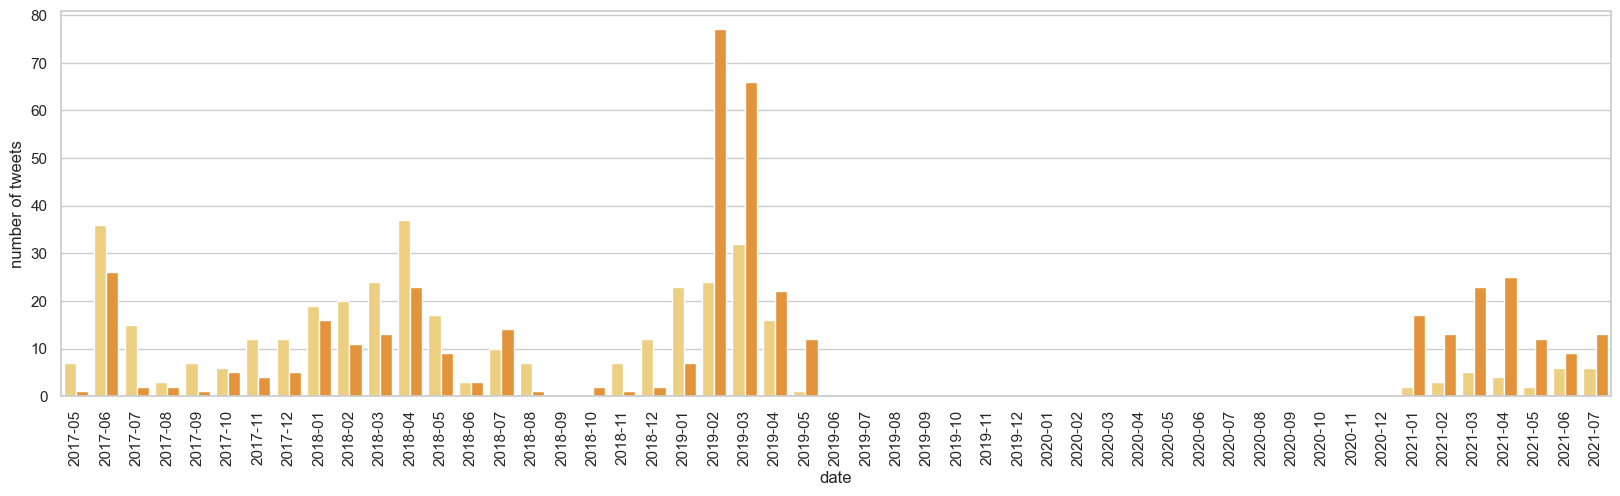

In [28]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="whitegrid")

#bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_us_politicians_stats_party_split, hue = "party", palette=cols)

#bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_us_politicians_stats_party_split, hue = "party", palette=cols_climate, )

bar3 = sns.barplot(x="date",  y="downplaying_tweets", data=full_monthly_aggregated_us_politicians_stats_party_split, hue = "party", palette=cols_downplaying, )


bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)
bar3.set_ylabel("number of tweets")


plt.legend([],[], frameon=False)

### grouped by date

In [29]:
monthly_aggregated_us_politicians_stats_full = politicians_us_data.groupby(pd.to_datetime(politicians_us_data['date']).dt.to_period(freq="M")).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

monthly_aggregated_us_politicians_stats_full['climate_ratio'] = monthly_aggregated_us_politicians_stats_full['climate_tweets'] / monthly_aggregated_us_politicians_stats_full['total_tweets']


monthly_aggregated_us_politicians_stats_full.head(6)

,date,total_tweets,climate_tweets,downplaying_tweets,climate_ratio
0,2017-05,7093,163,8.0,0.022980
1,2017-06,20716,574,62.0,0.027708
2,2017-07,14372,120,17.0,0.008350
3,2017-08,7668,47,5.0,0.006129
4,2017-09,6156,43,8.0,0.006985
5,2017-10,9885,88,11.0,0.008902


In [30]:

full_monthly_aggregated_us_politicians_stats_full = pd.merge(full_date_series,monthly_aggregated_us_politicians_stats_full,
            on = "date",
            how = "left")

Text(0, 0.5, 'number of tweets')

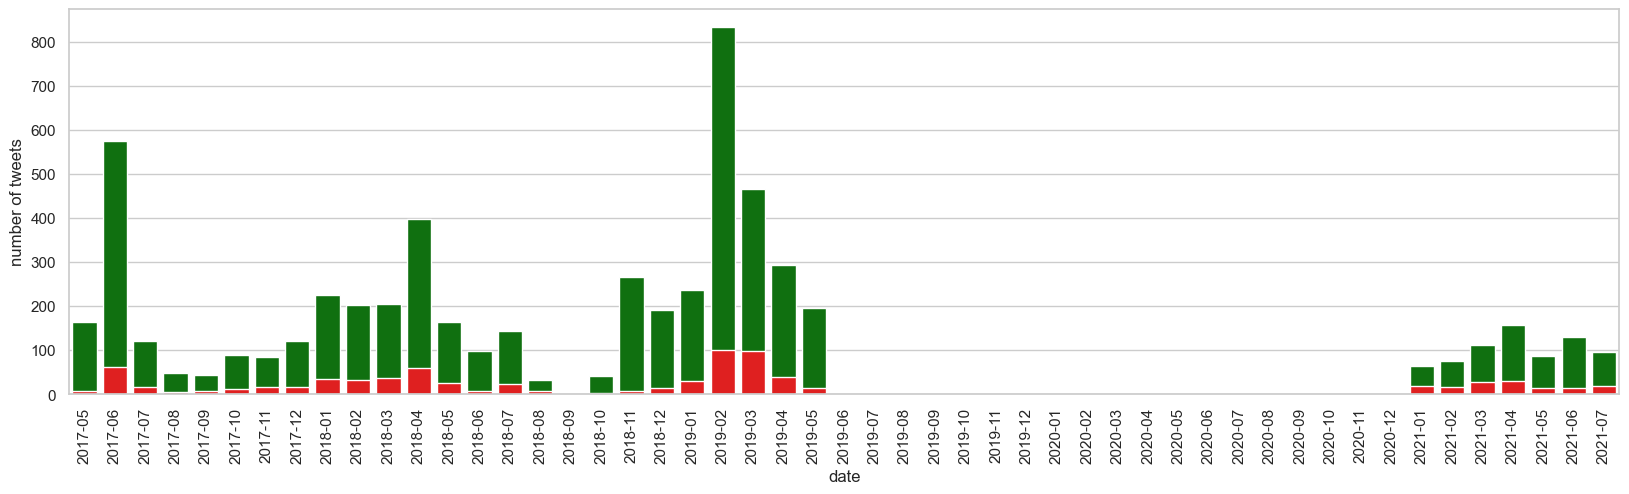

In [31]:
plt.figure(figsize=(20, 5))
#bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_us_politicians_stats_full, color='grey')
bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_us_politicians_stats_full, color='green')
bar3 = sns.barplot(x = "date", y= "downplaying_tweets", data=full_monthly_aggregated_us_politicians_stats_full, color='red')

bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)

bar3.set_ylabel("number of tweets")


## Macro Analysis: 2017 - 2019 (and 2021)

### Bigram Analysis to discover topics

In [32]:
# source: 
# https://medium.com/@melody.zapotoczny/a-quick-easy-guide-to-text-analysis-seaborn-4c1a20addba3


def counter(input):
    cnt = Counter()
    for sentences in input:
        for sentence in sentences:
            cnt[sentence] += 1
    return cnt


Text(0.5, 1.0, '2021 frequent trigrams Republican')

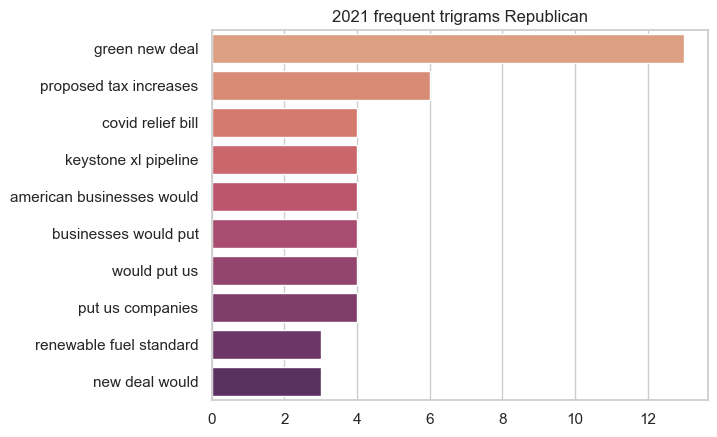

In [33]:
# plot the top n ngrams for each party and each year

year_plot = 2021
party_plot = "Republican"
x,y=map(list,zip(*counter(politicians_us_data['trigram_text'][(politicians_us_data['climate_related_pred'] == 1) & 
                                                              (politicians_us_data['downplaying_pred'] == 1) &
                                                              (politicians_us_data['year'] == year_plot) &
                                                              (politicians_us_data['party'] == party_plot)
                                                                            ]).most_common(10)))

# turn the tuples into a combined string
for i in range(len(x)):
    x[i] = ' '.join(x[i])

sns.barplot(x=y,y=x, palette="flare").set_title(str(year_plot) + " frequent trigrams "+ party_plot)

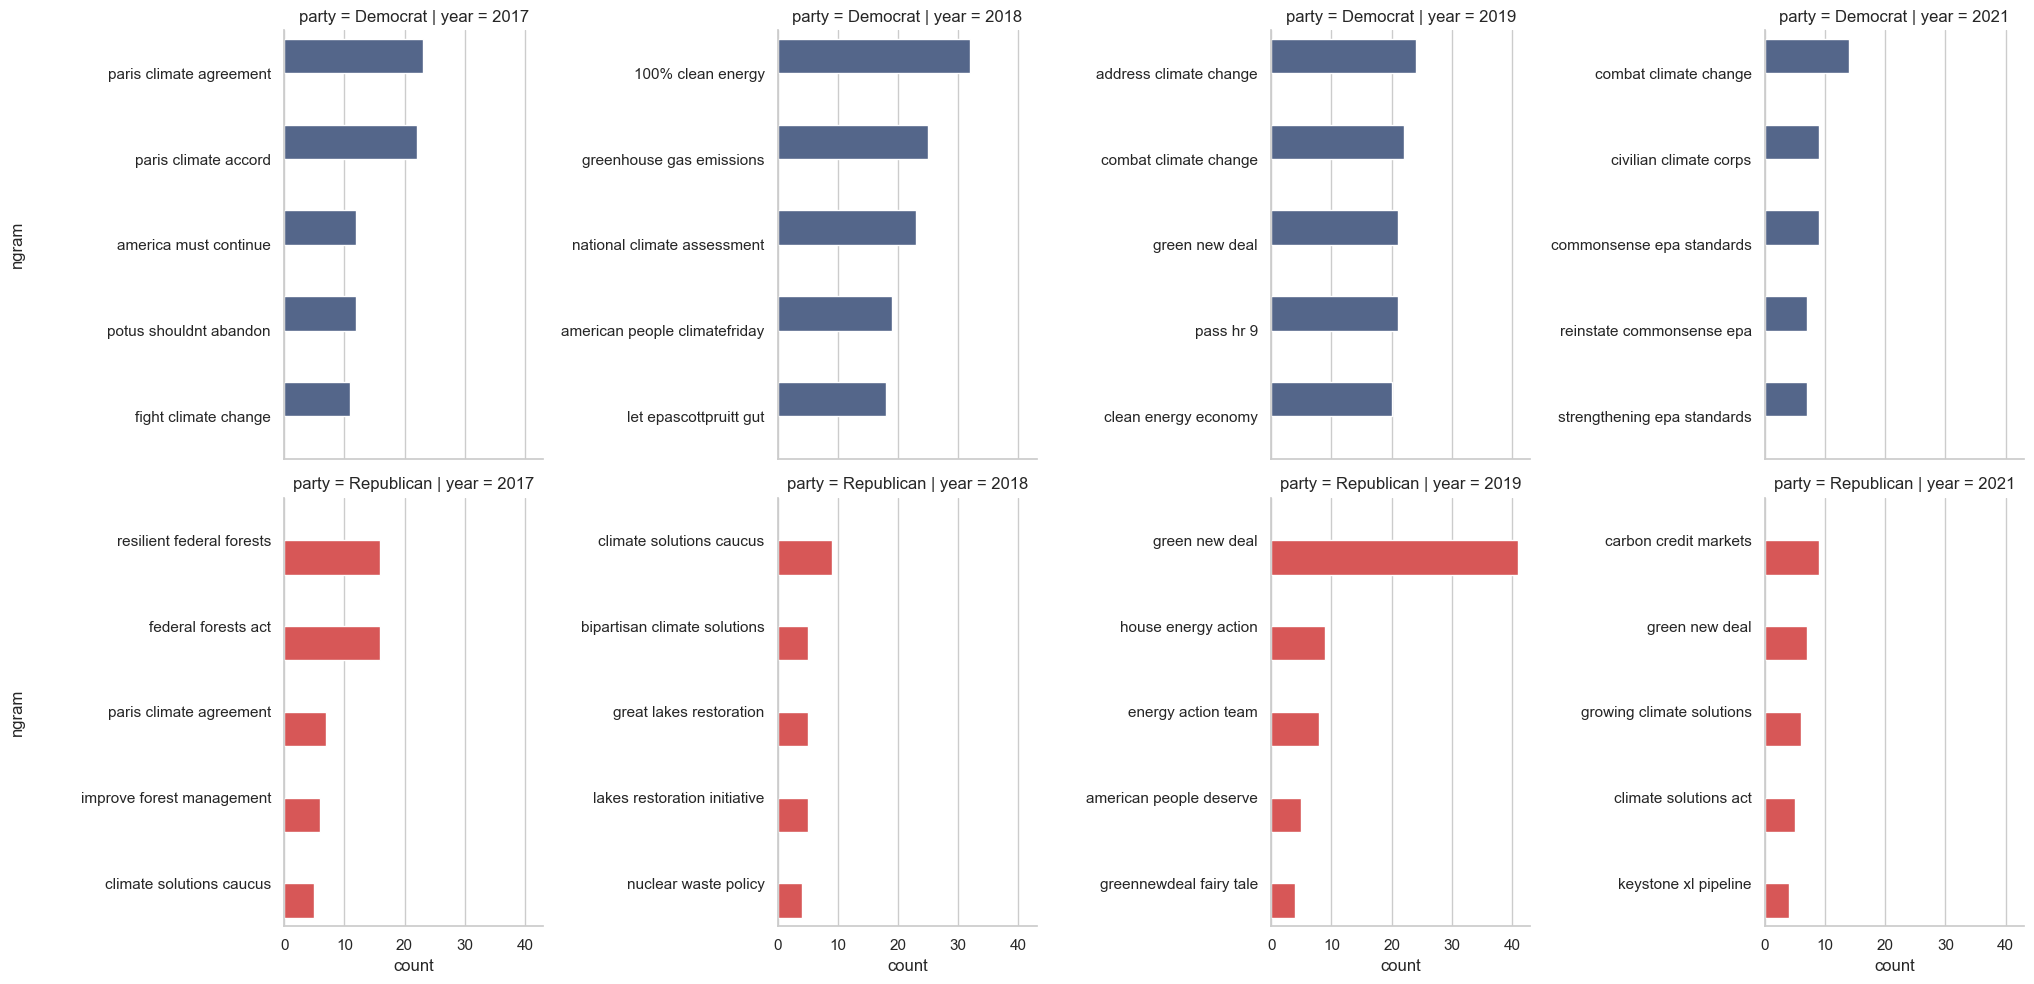

In [34]:
# create list of years and parties to plot
year_plots = [2017, 2018, 2019, 2021]
party_plots = ["Democrat", 
               "Republican",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get bigram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_us_data['trigram_text'][(politicians_us_data['climate_related_pred'] == 1) & 
                                                              (politicians_us_data['downplaying_pred'] == 0) &
                                                              (politicians_us_data['year'] == year_plot) &
                                                              (politicians_us_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# create long dataframe
#df = pd.DataFrame(results)

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = cols, 
            sharey=False, 
            sharex = True,
        )
        

for ax in g.axes.flatten():
    ax.get_yaxis().set_label_coords(-1,0.5)

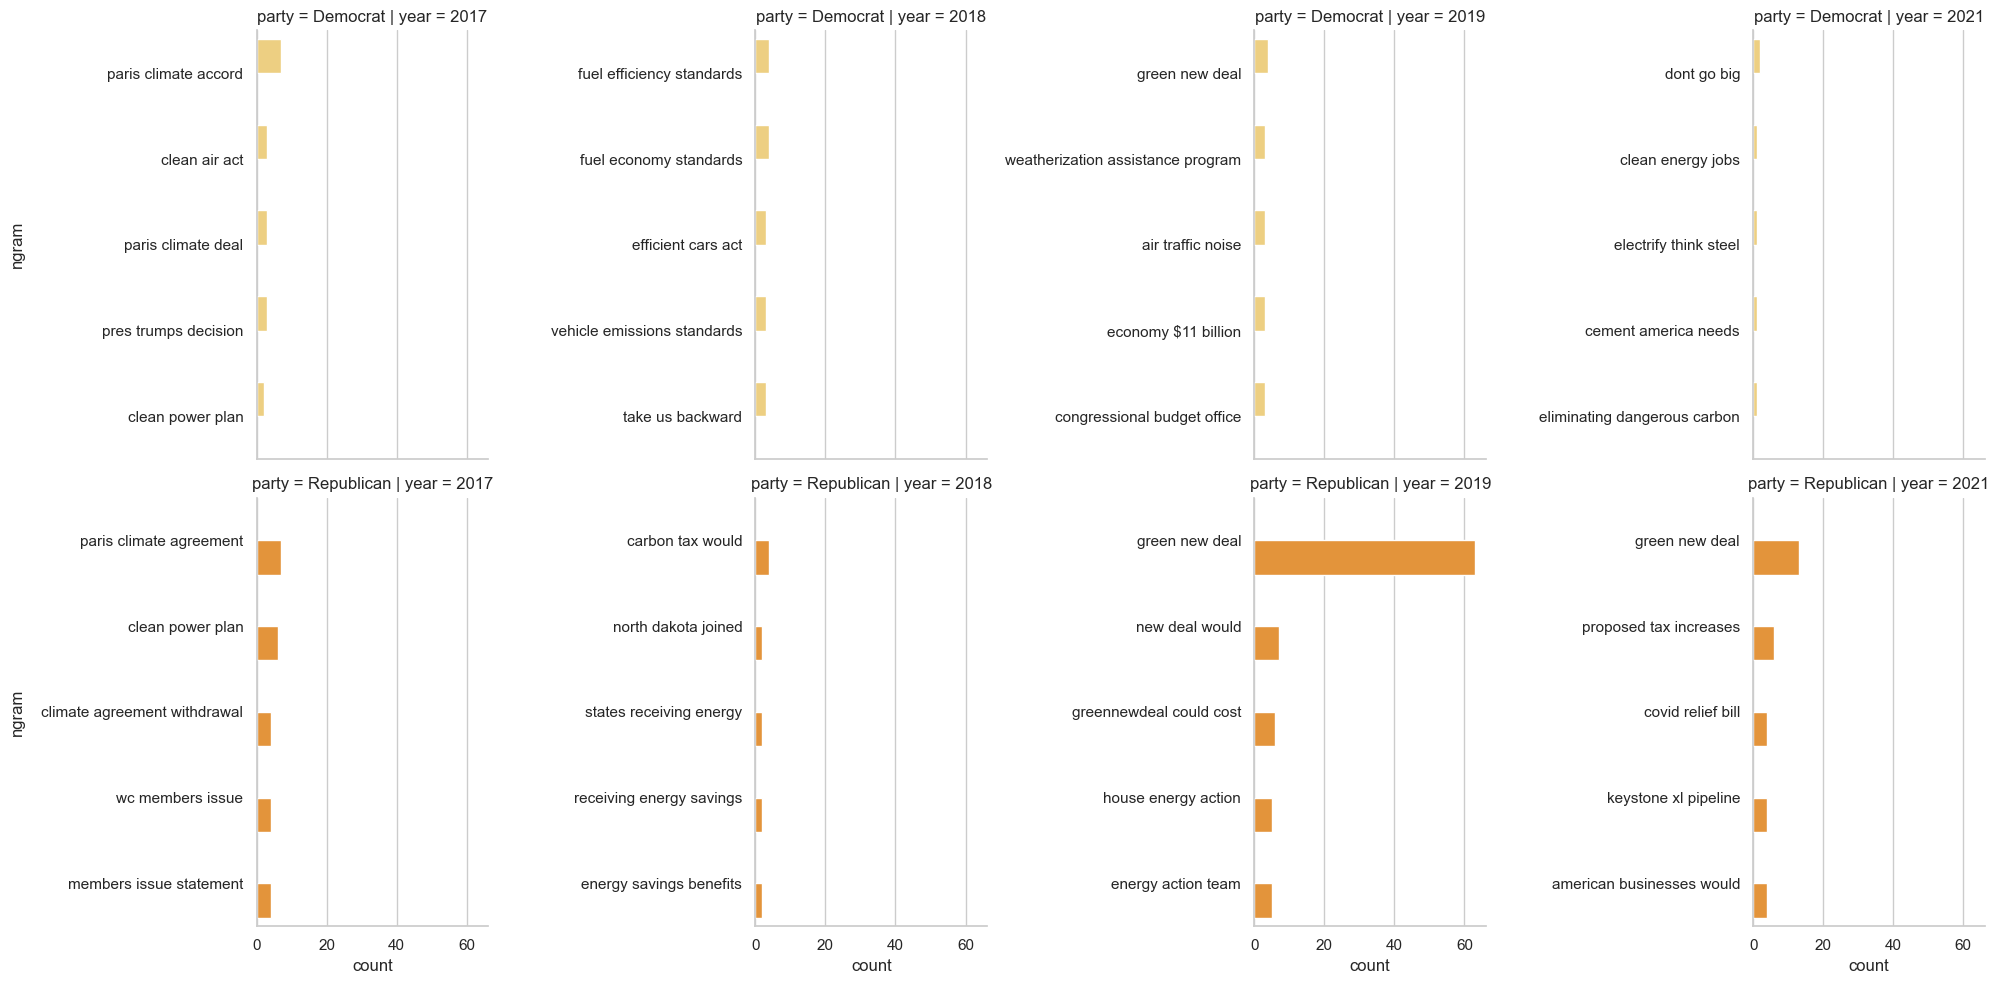

In [35]:
# create list of years and parties to plot
year_plots = [2017, 2018, 2019, 2021]
party_plots = ["Democrat", 
               "Republican",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get bigram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_us_data['trigram_text'][(politicians_us_data['climate_related_pred'] == 1) & 
                                                              (politicians_us_data['downplaying_pred'] == 1) &
                                                              (politicians_us_data['year'] == year_plot) &
                                                              (politicians_us_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# create long dataframe
#df = pd.DataFrame(results)

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = cols_downplaying, 
            sharey=False, 
            sharex = True,
        )
        

for ax in g.axes.flatten():
    ax.get_yaxis().set_label_coords(-1,0.5)

### summary stats us politcians downplaying ratios (grouped by politcian)

In [36]:
summary_stats_us_politicians = politicians_us_data.groupby("name").agg(
    
    party = ('party', lambda x: x.unique()[0]),

    first_tweet = ('date', lambda x: pd.to_datetime(x).min()),

    last_tweet = ('date', lambda x: pd.to_datetime(x).max()),

    total_tweets = ('cleaned_text', 'count'),

    mean_followers = ("followers", lambda x: x.mean().round(1)),

    climate_related =('climate_related_pred', sum),
    
    downplaying=('downplaying_pred', sum),


)

summary_stats_us_politicians['climate_ratio'] = summary_stats_us_politicians['climate_related'] / summary_stats_us_politicians['total_tweets']
summary_stats_us_politicians['downplaying_ratio'] = summary_stats_us_politicians['downplaying'] / summary_stats_us_politicians['climate_related']
summary_stats_us_politicians['downplaying_ratio'] = summary_stats_us_politicians['downplaying_ratio'].fillna(0)

summary_stats_us_politicians['underscoring_ratio'] = 1 - summary_stats_us_politicians['downplaying_ratio']

summary_stats_us_politicians.reset_index(inplace=True)

In [37]:
summary_stats_us_politicians

,name,party,first_tweet,last_tweet,total_tweets,mean_followers,climate_related,downplaying,climate_ratio,downplaying_ratio,underscoring_ratio
0,Alexandria Ocasio-Cortez,Democrat,2019-05-06 16:40:05,2019-05-06 16:40:05,1,13473668.0,0,0.0,0.000000,0.000000,1.000000
1,Antonio Delgado,Democrat,2019-05-06 18:03:31,2019-05-06 21:07:07,2,34435.0,0,0.0,0.000000,0.000000,1.000000
2,Ayanna Pressley,Democrat,2019-05-06 02:15:06,2019-05-06 20:57:11,5,1057638.4,0,0.0,0.000000,0.000000,1.000000
3,Ben McAdams,Democrat,2019-05-06 17:50:16,2019-05-06 17:50:16,1,15966.0,0,0.0,0.000000,0.000000,1.000000
4,Bradley Schneider,Democrat,2019-05-06 16:12:26,2019-05-06 17:34:33,2,19448.0,0,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
409,"william ""lacy"" clay jr.",Democrat,2017-05-22 19:01:27,2019-05-07 03:10:22,7415,10985.1,65,4.0,0.008766,0.061538,0.938462
410,william keating,Democrat,2017-05-24 14:04:28,2019-05-02 19:49:06,140,24430.2,2,0.0,0.014286,0.000000,1.000000
411,xavier becerra,Democrat,2017-05-27 02:12:11,2019-01-10 15:34:41,274,55623.1,7,1.0,0.025547,0.142857,0.857143
412,yvette d. clarke,Democrat,2017-05-22 19:04:26,2019-05-07 03:20:23,1683,84373.7,38,1.0,0.022579,0.026316,0.973684


In [38]:
summary_stats_us_politicians_na_filtered = summary_stats_us_politicians#.dropna().reset_index(drop=True)

In [39]:
summary_stats_us_politicians_na_filtered

,name,party,first_tweet,last_tweet,total_tweets,mean_followers,climate_related,downplaying,climate_ratio,downplaying_ratio,underscoring_ratio
0,Alexandria Ocasio-Cortez,Democrat,2019-05-06 16:40:05,2019-05-06 16:40:05,1,13473668.0,0,0.0,0.000000,0.000000,1.000000
1,Antonio Delgado,Democrat,2019-05-06 18:03:31,2019-05-06 21:07:07,2,34435.0,0,0.0,0.000000,0.000000,1.000000
2,Ayanna Pressley,Democrat,2019-05-06 02:15:06,2019-05-06 20:57:11,5,1057638.4,0,0.0,0.000000,0.000000,1.000000
3,Ben McAdams,Democrat,2019-05-06 17:50:16,2019-05-06 17:50:16,1,15966.0,0,0.0,0.000000,0.000000,1.000000
4,Bradley Schneider,Democrat,2019-05-06 16:12:26,2019-05-06 17:34:33,2,19448.0,0,0.0,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
409,"william ""lacy"" clay jr.",Democrat,2017-05-22 19:01:27,2019-05-07 03:10:22,7415,10985.1,65,4.0,0.008766,0.061538,0.938462
410,william keating,Democrat,2017-05-24 14:04:28,2019-05-02 19:49:06,140,24430.2,2,0.0,0.014286,0.000000,1.000000
411,xavier becerra,Democrat,2017-05-27 02:12:11,2019-01-10 15:34:41,274,55623.1,7,1.0,0.025547,0.142857,0.857143
412,yvette d. clarke,Democrat,2017-05-22 19:04:26,2019-05-07 03:20:23,1683,84373.7,38,1.0,0.022579,0.026316,0.973684


In [40]:
politicians_LCV_scores['LCV_lifetime_score_decimal'] = politicians_LCV_scores['LCV_lifetime_score']/100

temp_df = pd.merge(summary_stats_us_politicians_na_filtered,politicians_LCV_scores, 
                left_on = "name",
                right_on = "politician",
                how = "left"
                )

summary_stats_us_politicians_na_filtered['LCV_lifetime_score_decimal'] = temp_df['LCV_lifetime_score_decimal']

mapping_dict = dict(zip(wynes_mapping.Wayne, wynes_mapping.vanVliet))

wynes_2022_politician_data['mapped_name'] = wynes_2022_politician_data['name'].map(mapping_dict)

summary_stats_us_politicians_na_filtered = pd.merge(summary_stats_us_politicians_na_filtered,wynes_2022_politician_data[['mapped_name','pro_clim','anti_clim','tweet_total','clim_perc','net_proclim_twt_rate']], 
                left_on = "name",
                right_on = "mapped_name",
                how = "left"
                )

summary_stats_us_politicians_na_filtered = pd.merge(summary_stats_us_politicians_na_filtered,us_politicians_birthyear,
         on = "name",
         how = "left")



summary_stats_us_politicians_na_filtered = pd.merge(summary_stats_us_politicians_na_filtered,us_politicians_region[['name','region']],
         on = "name",
         how = "left")

In [41]:
summary_stats_us_politicians_na_filtered['climate_ratio_wynes'] = (summary_stats_us_politicians_na_filtered['pro_clim'] + summary_stats_us_politicians_na_filtered['anti_clim'])/summary_stats_us_politicians_na_filtered['tweet_total']

summary_stats_us_politicians_na_filtered['climate_ratio_wynes'].fillna(0,inplace=True)


summary_stats_us_politicians_na_filtered['downplaying_ratio_wynes'] = summary_stats_us_politicians_na_filtered['anti_clim']/(summary_stats_us_politicians_na_filtered['pro_clim'] + summary_stats_us_politicians_na_filtered['anti_clim'])
summary_stats_us_politicians_na_filtered['downplaying_ratio_wynes'].fillna(0,inplace=True)

summary_stats_us_politicians_na_filtered['net_proclim_twt_rate_hemmi'] = ((summary_stats_us_politicians_na_filtered['climate_related']-summary_stats_us_politicians_na_filtered['downplaying'])-summary_stats_us_politicians_na_filtered['downplaying'])/summary_stats_us_politicians_na_filtered['total_tweets']

In [42]:
summary_stats_us_politicians_na_filtered

,name,party,first_tweet,last_tweet,total_tweets,mean_followers,climate_related,downplaying,climate_ratio,downplaying_ratio,...,pro_clim,anti_clim,tweet_total,clim_perc,net_proclim_twt_rate,birth_year,region,climate_ratio_wynes,downplaying_ratio_wynes,net_proclim_twt_rate_hemmi
0,Alexandria Ocasio-Cortez,Democrat,2019-05-06 16:40:05,2019-05-06 16:40:05,1,13473668.0,0,0.0,0.000000,0.000000,...,49.0,0.0,1515.0,0.032343,0.032343,1989,New York,0.032343,0.0,0.000000
1,Antonio Delgado,Democrat,2019-05-06 18:03:31,2019-05-06 21:07:07,2,34435.0,0,0.0,0.000000,0.000000,...,28.0,0.0,1448.0,0.019337,0.019337,1989,New York,0.019337,0.0,0.000000
2,Ayanna Pressley,Democrat,2019-05-06 02:15:06,2019-05-06 20:57:11,5,1057638.4,0,0.0,0.000000,0.000000,...,23.0,0.0,2478.0,0.009282,0.009282,1974,Massachusetts,0.009282,0.0,0.000000
3,Ben McAdams,Democrat,2019-05-06 17:50:16,2019-05-06 17:50:16,1,15966.0,0,0.0,0.000000,0.000000,...,3.0,0.0,271.0,0.011070,0.011070,1974,Utah,0.011070,0.0,0.000000
4,Bradley Schneider,Democrat,2019-05-06 16:12:26,2019-05-06 17:34:33,2,19448.0,0,0.0,0.000000,0.000000,...,4.0,0.0,443.0,0.009029,0.009029,1961,Illinois,0.009029,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,"william ""lacy"" clay jr.",Democrat,2017-05-22 19:01:27,2019-05-07 03:10:22,7415,10985.1,65,4.0,0.008766,0.061538,...,13.0,0.0,2087.0,0.006229,0.006229,1956,Missouri,0.006229,0.0,0.007687
410,william keating,Democrat,2017-05-24 14:04:28,2019-05-02 19:49:06,140,24430.2,2,0.0,0.014286,0.000000,...,0.0,0.0,67.0,0.000000,0.000000,1952,Massachusetts,0.000000,0.0,0.014286
411,xavier becerra,Democrat,2017-05-27 02:12:11,2019-01-10 15:34:41,274,55623.1,7,1.0,0.025547,0.142857,...,NaN,NaN,NaN,NaN,NaN,1958,California,0.000000,0.0,0.018248
412,yvette d. clarke,Democrat,2017-05-22 19:04:26,2019-05-07 03:20:23,1683,84373.7,38,1.0,0.022579,0.026316,...,8.0,0.0,384.0,0.020833,0.020833,1964,New York,0.020833,0.0,0.021390


## Understanding the downplaying classified tweets of Democrats

In [43]:
summary_stats_us_politicians_na_filtered.head(1)

,name,party,first_tweet,last_tweet,total_tweets,mean_followers,climate_related,downplaying,climate_ratio,downplaying_ratio,...,pro_clim,anti_clim,tweet_total,clim_perc,net_proclim_twt_rate,birth_year,region,climate_ratio_wynes,downplaying_ratio_wynes,net_proclim_twt_rate_hemmi
0,Alexandria Ocasio-Cortez,Democrat,2019-05-06 16:40:05,2019-05-06 16:40:05,1,13473668.0,0,0.0,0.0,0.0,...,49.0,0.0,1515.0,0.032343,0.032343,1989,New York,0.032343,0.0,0.0


In [44]:
plot_democrats_downplaying = summary_stats_us_politicians_na_filtered[(summary_stats_us_politicians_na_filtered["party"]=="Democrat")&(summary_stats_us_politicians_na_filtered['downplaying'] >= 1)][['name','downplaying','climate_related','downplaying_ratio','net_proclim_twt_rate_hemmi']].sort_values(by = "downplaying", ascending = False).reset_index(drop = True)
plot_democrats_downplaying.head(10)

,name,downplaying,climate_related,downplaying_ratio,net_proclim_twt_rate_hemmi
0,don beyer,59.0,331,0.178248,0.037981
1,paul d. tonko,17.0,107,0.158879,0.050765
2,martin heinrich,15.0,250,0.060000,0.223805
3,scott peters,12.0,99,0.121212,0.040894
4,frank pallone jr.,10.0,122,0.081967,0.040444
5,daniel lipinski,9.0,54,0.166667,0.044832
6,kathy castor,9.0,138,0.065217,0.090978
7,rick larsen,8.0,46,0.173913,0.014663
8,dianne feinstein,8.0,132,0.060606,0.104977
9,joaquin castro,6.0,25,0.240000,0.003450


Text(0.5, 0, 'number of downplaying tweets')

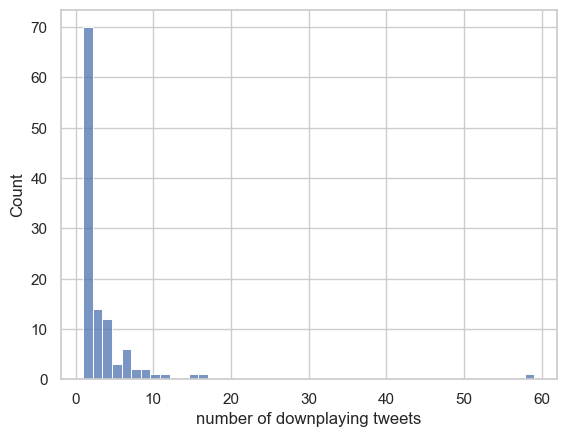

In [45]:
sns.histplot(data = plot_democrats_downplaying,
                x = "downplaying")

plt.xlabel("number of downplaying tweets")

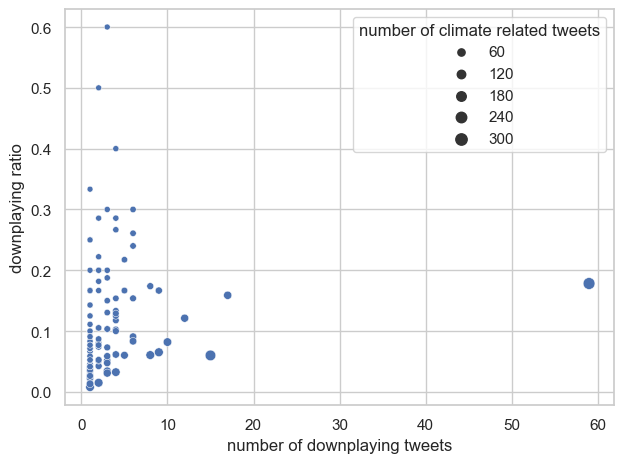

In [46]:
sns.scatterplot(data = plot_democrats_downplaying,
                x = "downplaying",
                y = "downplaying_ratio",
                size = "climate_related")

plt.ylabel("downplaying ratio")
plt.xlabel("number of downplaying tweets")
plt.legend(title = "number of climate related tweets")

plt.tight_layout()

<Axes: xlabel='downplaying'>

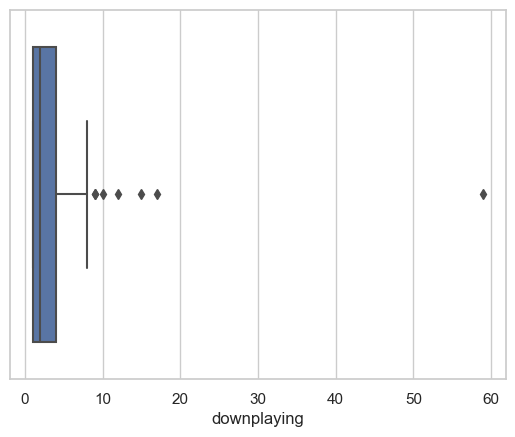

In [47]:
sns.boxplot(x = "downplaying",
            data = plot_democrats_downplaying)

<Axes: xlabel='downplaying_ratio'>

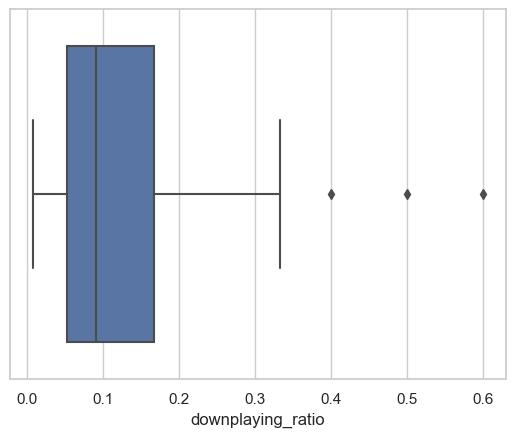

In [48]:
sns.boxplot(x = "downplaying_ratio",
            data = plot_democrats_downplaying)

<Axes: xlabel='net_proclim_twt_rate_hemmi'>

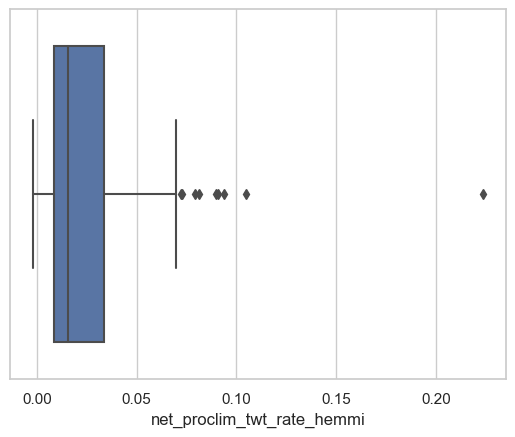

In [49]:
sns.boxplot(x = "net_proclim_twt_rate_hemmi",
            data = plot_democrats_downplaying)

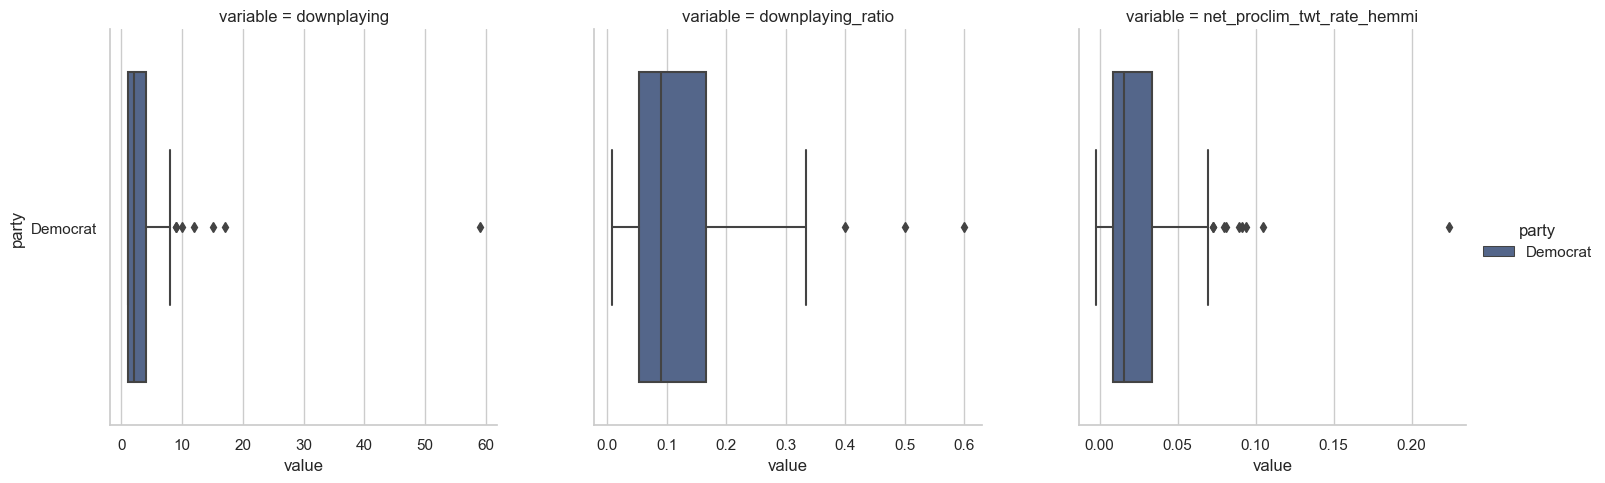

In [50]:
sns.set_style("whitegrid")

g = sns.catplot(
            x='value', 
            y='party', 
            col = "variable", 
            #row = "party", 
            data= summary_stats_us_politicians_na_filtered[(summary_stats_us_politicians_na_filtered["party"]=="Democrat")&(summary_stats_us_politicians_na_filtered['downplaying'] >= 1)][['name','party','downplaying','downplaying_ratio','net_proclim_twt_rate_hemmi']].melt(id_vars=["party","name"]), 
            kind="box", 
            hue = "party", 
            palette = cols, 
            sharey=True, 
            sharex = False,
        )


#plt.tight_layout()

plt.subplots_adjust(wspace=0.25)

## Comparison Plots and correlation with Wynes 2022

In [51]:
test_summary_stats_us_politicians_na_filtered = summary_stats_us_politicians_na_filtered.dropna(subset = ["net_proclim_twt_rate"])

In [52]:
len(test_summary_stats_us_politicians_na_filtered)

319

climate ratio comparison

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


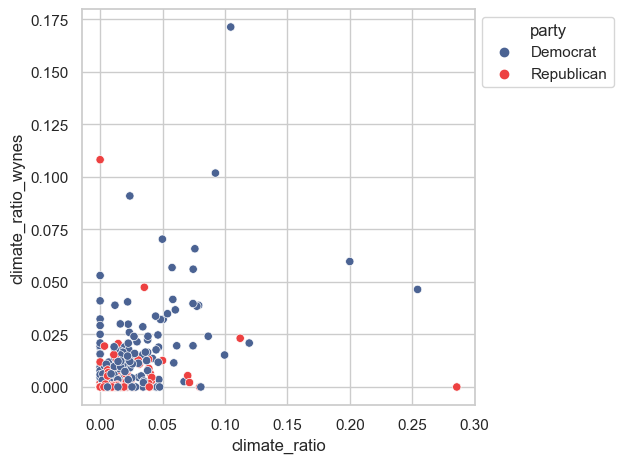

In [53]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "climate_ratio",
                y = "climate_ratio_wynes" ,
                hue = "party",
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

plt.tight_layout()

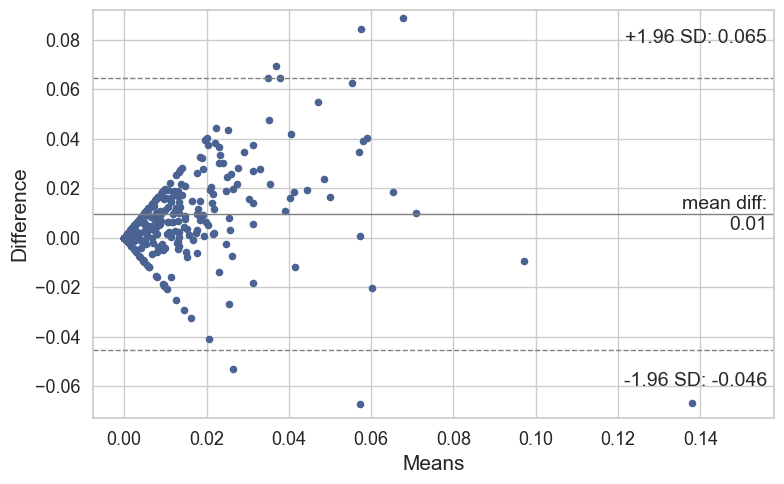

In [54]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered['climate_ratio'],
                           test_summary_stats_us_politicians_na_filtered['climate_ratio_wynes'], 
                           scatter_kwds={"color":cols['Democrat']},
                           ax = ax,
                           )

plt.tight_layout()

In [55]:
np.corrcoef(test_summary_stats_us_politicians_na_filtered['climate_ratio'],
            test_summary_stats_us_politicians_na_filtered['climate_ratio_wynes'])

array([[1.        , 0.41740495],
       [0.41740495, 1.        ]])

downplaying ratios comparison

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


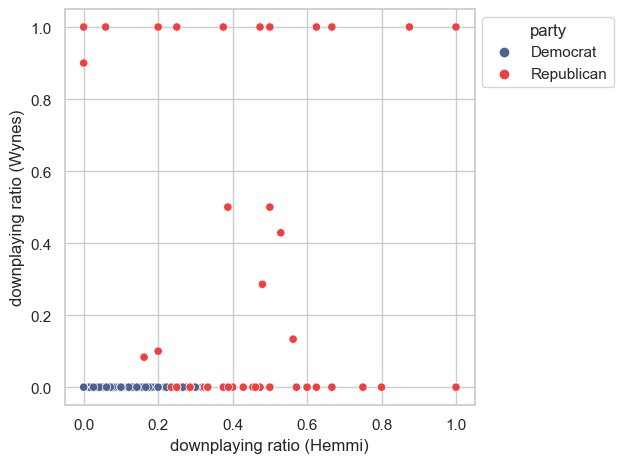

In [56]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "downplaying_ratio_wynes" ,
                hue = "party",
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

plt.xlabel("downplaying ratio (Hemmi)")
plt.ylabel("downplaying ratio (Wynes)")



plt.tight_layout()

In [57]:
np.corrcoef(test_summary_stats_us_politicians_na_filtered['downplaying_ratio'],
            test_summary_stats_us_politicians_na_filtered['downplaying_ratio_wynes'])

array([[1.        , 0.23325778],
       [0.23325778, 1.        ]])

In [58]:
np.corrcoef(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['climate_related']>15]['downplaying_ratio'],
            test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['climate_related']>15]['downplaying_ratio_wynes'])

array([[1.        , 0.50607545],
       [0.50607545, 1.        ]])

Net Proclimate Tweet Rate

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


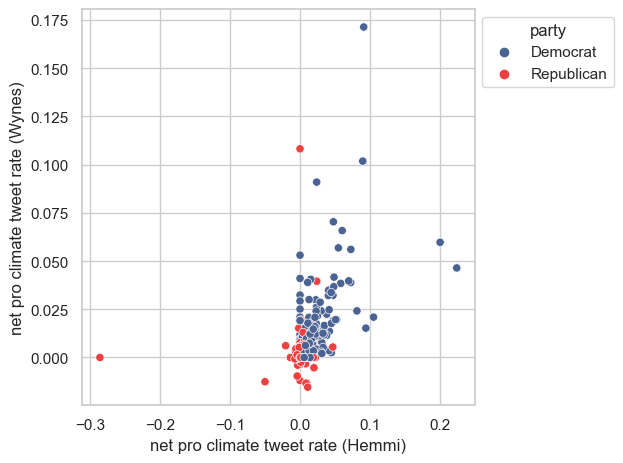

In [59]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "net_proclim_twt_rate_hemmi",
                y = "net_proclim_twt_rate" ,
                hue = "party",
                #size = "mean_followers",
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)



plt.xlabel("net pro climate tweet rate (Hemmi)")
plt.ylabel("net pro climate tweet rate (Wynes)")




plt.tight_layout()

In [60]:
np.corrcoef(test_summary_stats_us_politicians_na_filtered['net_proclim_twt_rate_hemmi'],
            test_summary_stats_us_politicians_na_filtered['net_proclim_twt_rate'])

array([[1.        , 0.47033041],
       [0.47033041, 1.        ]])

In [61]:
np.corrcoef(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['climate_related']>15]['net_proclim_twt_rate_hemmi'],
            test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['climate_related']>15]['net_proclim_twt_rate'])

array([[1.        , 0.55611174],
       [0.55611174, 1.        ]])

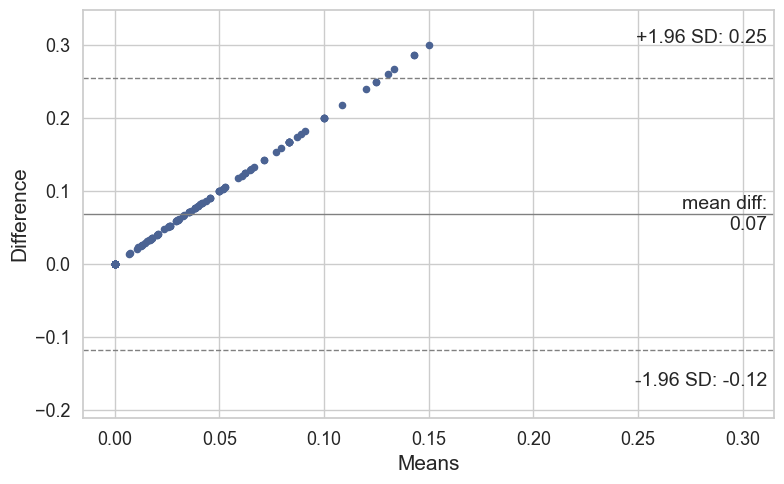

In [62]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['downplaying_ratio'],
                           test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['downplaying_ratio_wynes'], 
                           scatter_kwds={"color":cols['Democrat']},
                           ax = ax)

plt.tight_layout()

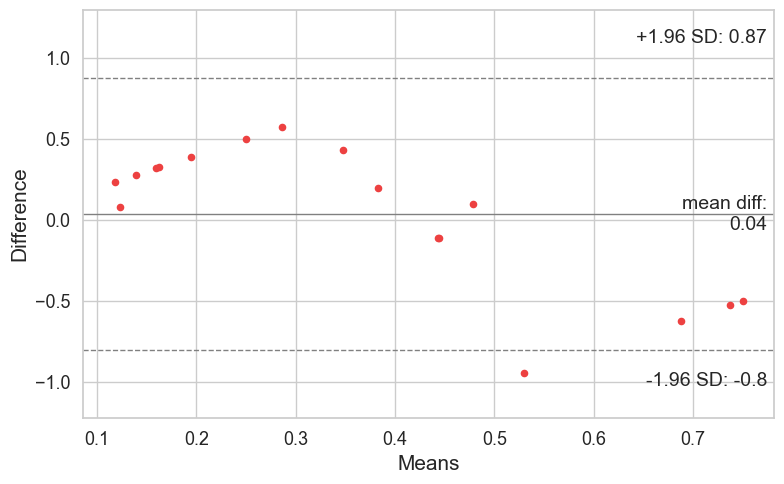

In [63]:

f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[(test_summary_stats_us_politicians_na_filtered['party']=="Republican")&(test_summary_stats_us_politicians_na_filtered['climate_related']>15)]['downplaying_ratio'],
                           test_summary_stats_us_politicians_na_filtered[(test_summary_stats_us_politicians_na_filtered['party']=="Republican")&(test_summary_stats_us_politicians_na_filtered['climate_related']>15)]['downplaying_ratio_wynes'], 
                           scatter_kwds={"color":cols['Republican']},
                           ax = ax)


plt.tight_layout()

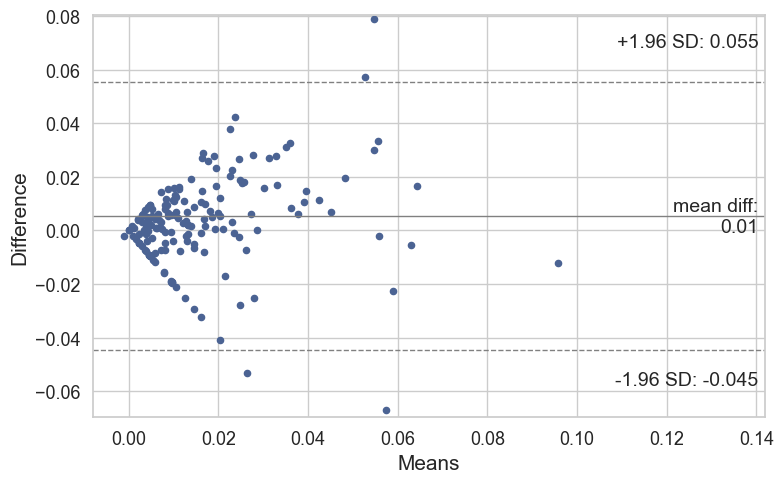

In [64]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['net_proclim_twt_rate_hemmi'],
                           test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['net_proclim_twt_rate'], 
                           scatter_kwds={"color":cols['Democrat']},
                           ax = ax)


plt.tight_layout()

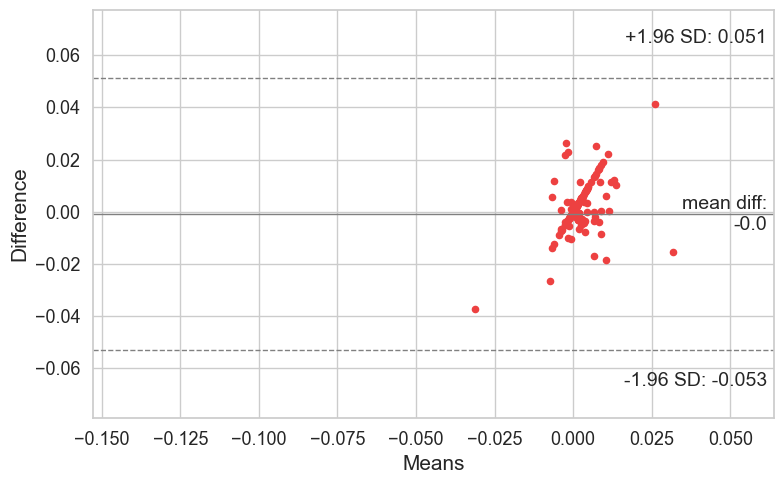

In [65]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Republican"]['net_proclim_twt_rate_hemmi'],
                           test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Republican"]['net_proclim_twt_rate'], 
                           scatter_kwds={"color":cols['Republican']},
                           ax = ax)


plt.tight_layout()

## using LCV Score as a proxy for climate-related voting behaviour

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


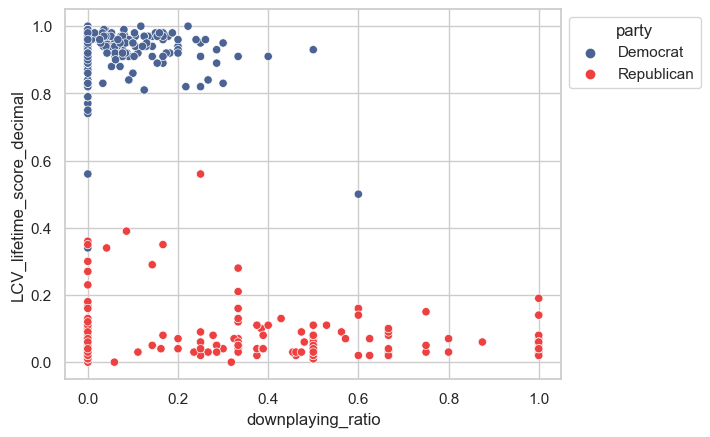

In [66]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "LCV_lifetime_score_decimal" ,
                hue = "party",
                #size = "mean_followers",
                palette= cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

In [67]:
np.corrcoef(summary_stats_us_politicians_na_filtered['LCV_lifetime_score_decimal'],summary_stats_us_politicians_na_filtered['climate_ratio'])

array([[1.        , 0.22762729],
       [0.22762729, 1.        ]])

In [68]:
np.corrcoef(summary_stats_us_politicians_na_filtered['LCV_lifetime_score_decimal'],summary_stats_us_politicians_na_filtered['downplaying_ratio'])

array([[ 1.        , -0.43860769],
       [-0.43860769,  1.        ]])

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


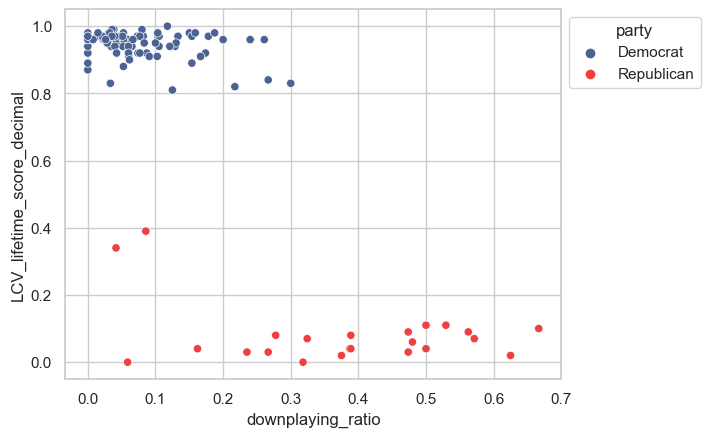

In [69]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered[summary_stats_us_politicians_na_filtered['climate_related']>=15],
                x = "downplaying_ratio",
                y = "LCV_lifetime_score_decimal" ,
                hue = "party",
                #size = "mean_followers",
                palette= cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

In [70]:
len(summary_stats_us_politicians_na_filtered)

414

In [71]:
np.corrcoef(summary_stats_us_politicians_na_filtered[summary_stats_us_politicians_na_filtered['climate_related']>=15]['LCV_lifetime_score_decimal'],summary_stats_us_politicians_na_filtered[summary_stats_us_politicians_na_filtered['climate_related']>=15]['downplaying_ratio'])


array([[ 1.        , -0.79834526],
       [-0.79834526,  1.        ]])

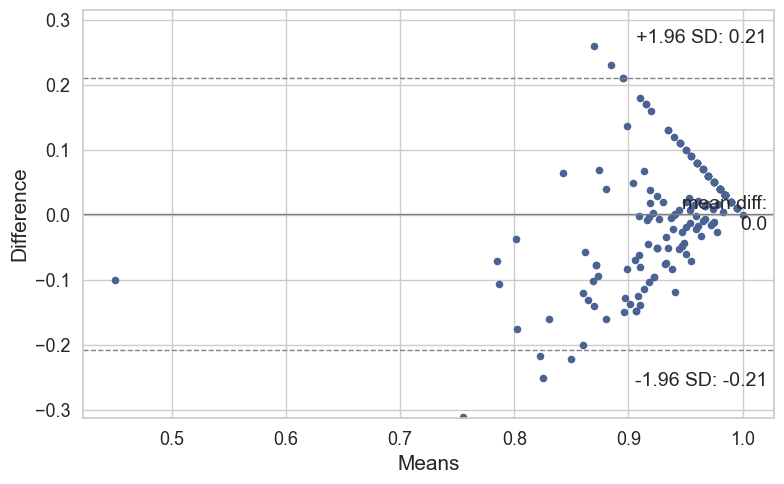

In [72]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['underscoring_ratio'],
                           test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Democrat"]['LCV_lifetime_score_decimal'], 
                           scatter_kwds={"color":cols['Democrat']},
                           ax = ax)


plt.tight_layout()

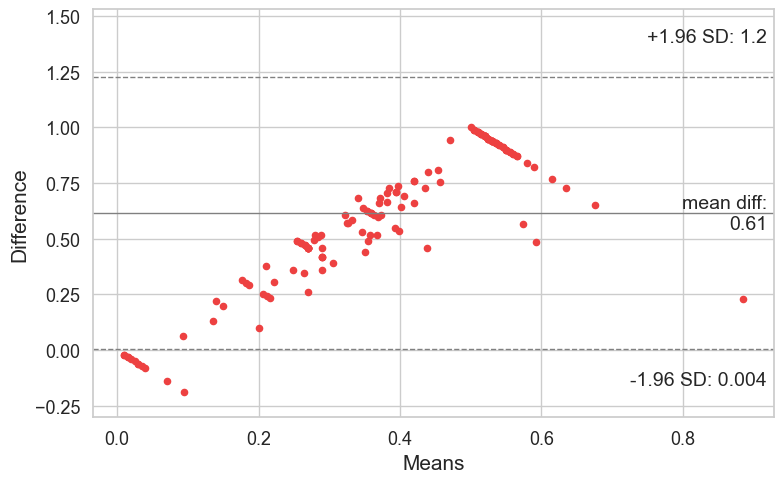

In [73]:
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Republican"]['underscoring_ratio'],
                           test_summary_stats_us_politicians_na_filtered[test_summary_stats_us_politicians_na_filtered['party']=="Republican"]['LCV_lifetime_score_decimal'], 
                           scatter_kwds={"color":cols['Republican']},
                           ax = ax)


plt.tight_layout()

### Other US politician plots (not sanity-testing)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


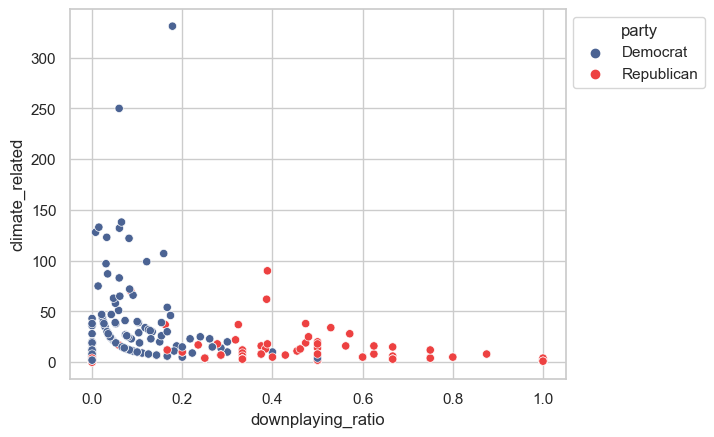

In [74]:
#sns.set_theme("whitegrid")

plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "climate_related" ,
                hue = "party",
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


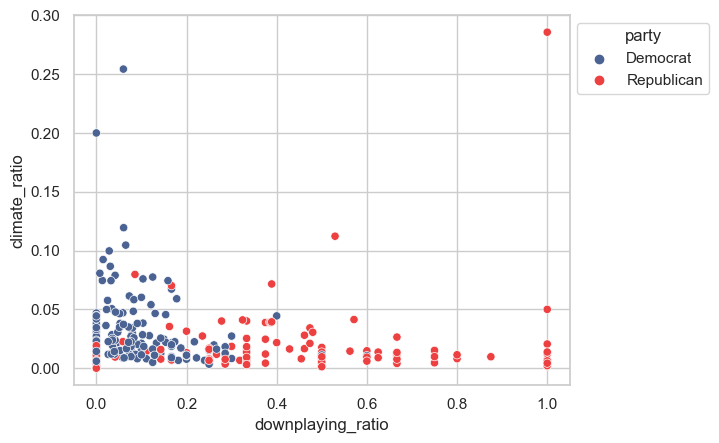

In [75]:

plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "climate_ratio" ,
                hue = "party",
                palette= cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


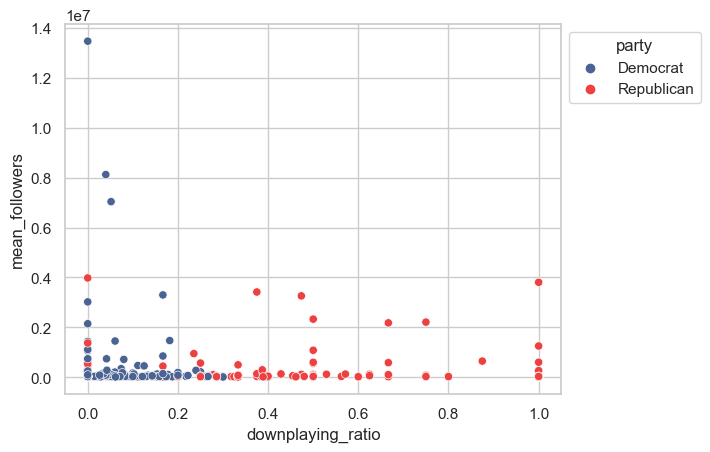

In [76]:
plot = sns.scatterplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "mean_followers" ,
                hue = "party",
                palette= cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


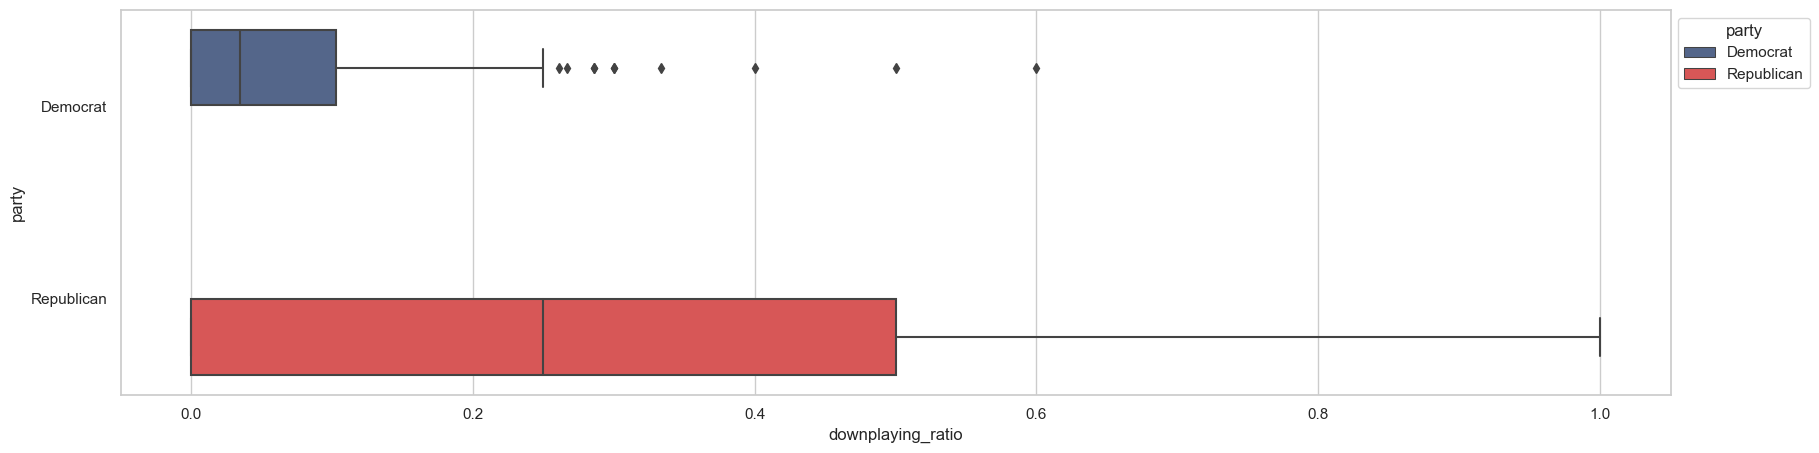

In [77]:
plt.figure(figsize=(20, 5))

plot = sns.boxplot(data = summary_stats_us_politicians_na_filtered,
                x = "downplaying_ratio",
                y = "party" ,
                hue = "party",
                palette= cols)
 
sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


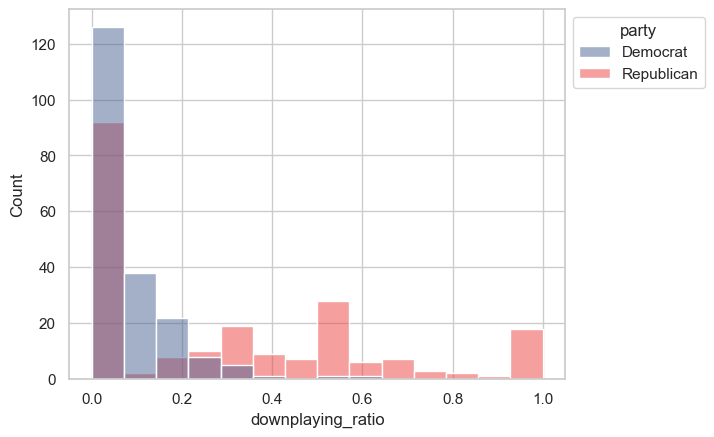

In [78]:
plot = sns.histplot(data = summary_stats_us_politicians_na_filtered,
                #x = "party",
                x = "downplaying_ratio" ,
                hue = "party",
                palette= cols,
                #bins=50,
                )


sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

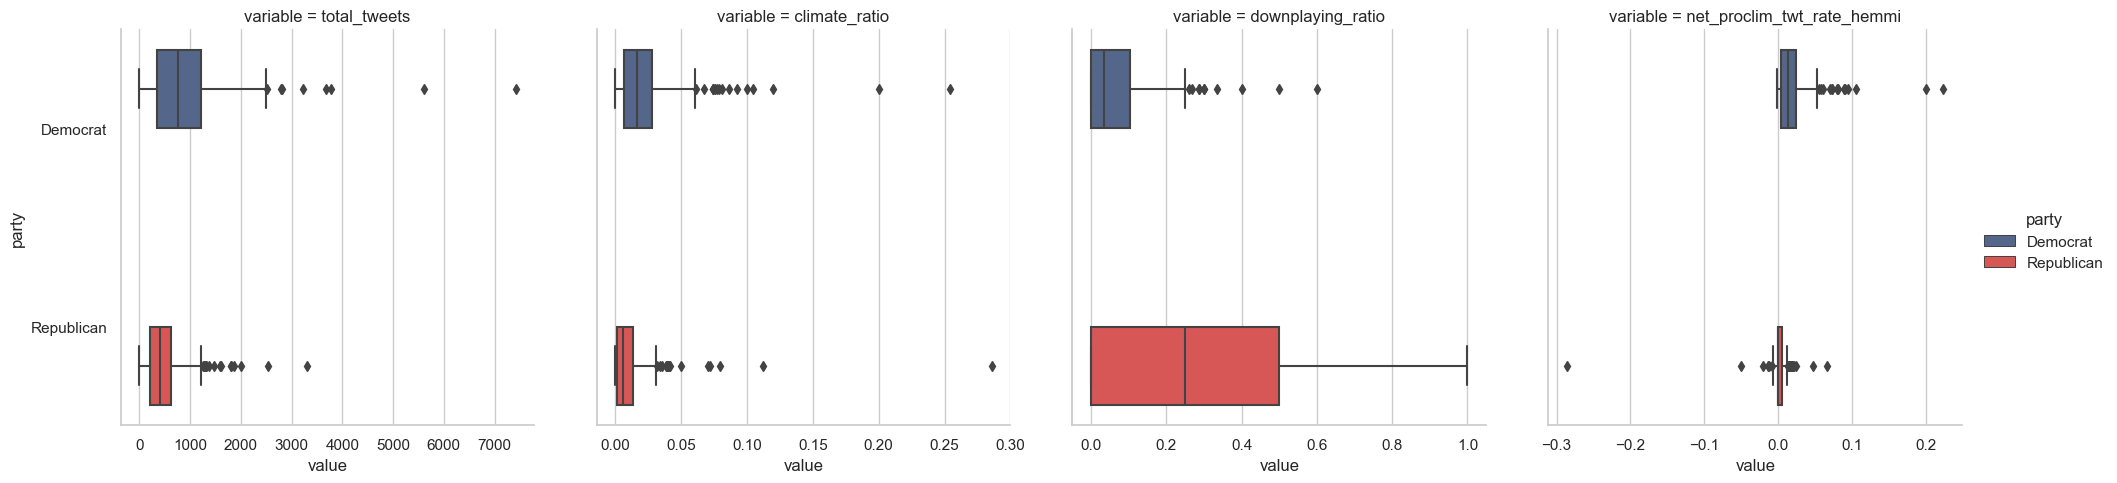

In [79]:
sns.set_style("whitegrid")

g = sns.catplot(
            x='value', 
            y='party', 
            col = "variable", 
            #row = "party", 
            data= summary_stats_us_politicians_na_filtered[["party","name","total_tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].melt(id_vars=["party","name"]), 
            kind="box", 
            hue = "party", 
            palette = cols, 
            sharey=True, 
            sharex = False,
        )

plt.subplots_adjust(wspace=0.15)
#plt.tight_layout()

In [80]:
summary_stats_us_politicians_na_filtered[["party","name","total_tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].groupby("party").agg(
    n_politicians = ("name", "count"),
    mean_total_tweet = ("total_tweets", lambda x: round(np.mean(x),2)),
    mean_climate_ratio = ("climate_ratio", lambda x: round(np.mean(x),2)),
    mean_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.mean(x),2)),
    mean_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.mean(x),2)),
    
    median_total_tweet = ("total_tweets", lambda x: round(np.median(x),2)),
    median_climate_ratio = ("climate_ratio", lambda x: round(np.median(x),2)),
    median_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.median(x),2)),
    median_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.median(x),2)),
)

,n_politicians,mean_total_tweet,mean_climate_ratio,mean_downplaying_ratio,mean_proclimate_twt_rate,median_total_tweet,median_climate_ratio,median_downplaying_ratio,median_proclimate_twt_rate
party,,,,,,,,,
Democrat,202,914.77,0.02,0.07,0.02,766.0,0.02,0.03,0.01
Republican,212,510.76,0.01,0.29,0.00,399.0,0.01,0.25,0.00


## Micro Analysis: Full timeseries of selected politicians

In [81]:
politicians_with_trump_tweets_data.name.unique()

array(['Al Gore', 'Alexandria Ocasio-Cortez', 'Barack Obama',
       "Beto O'Rourke", 'Congresswoman Chellie Pingree 🇺🇸 🇺🇦',
       'Rep. Jody Hice', 'David Cicilline', 'Elise Stefanik',
       'Jeff Fortenberry', 'Denny Heck', 'Tom Malinowski',
       'Martin Heinrich', 'Senator Mike Crapo', 'Pete Sessions',
       'Rep. Alex Mooney', 'Rep. Andy Barr', 'Rep. Andy Harris, MD',
       'Ann McLane Kuster', 'Ami Bera, M.D.', 'Rep. Bill Johnson',
       'US Rep Brendan Boyle', 'Rep. Brian Fitzpatrick 🇺🇸',
       'Matt Cartwright', 'Archive: Rep. Cheri Bustos',
       'Congressman Michael Cloud', 'Rep. Henry Cuellar',
       'Rep. Dan Crenshaw', 'Rep. Debbie Dingell', 'Rep. Don Beyer',
       'US Rep. Filemon Vela', 'Rep. Lizzie Fletcher',
       'Rep. Paul Gosar, DDS', 'Rep. Bill Huizenga', 'Rep. Jack Bergman',
       'James E. Clyburn', 'Hakeem Jeffries', 'Jim Banks', 'Judy Chu',
       'Rep. Liz Cheney', 'Mike Quigley', 'Rep. John Moolenaar',
       'Paul Tonko', 'Rep. August Pfluger', '

In [82]:
# source: Wikipedia

party_mapping = {
                 "Donald Trump":"Republican",
                 "Ted Cruz":"Republican",
                 "Rep. Don Beyer":"Democrat",
                 "Bernie Sanders":"Democrat",
                 "Kevin McCarthy":"Republican",
                 "Mike Quigley":"Democrat",
                 "Barack Obama":"Democrat",
                 "Rep. Paul Gosar, DDS":"Republican",
                 "Steve Scalise":"Republican",
                 "Paul Tonko":"Democrat",
                 "Alexandria Ocasio-Cortez":"Democrat",
                 "Beto O'Rourke":"Democrat",
                 "Rep. Scott Peters":"Democrat",
                 "Martin Heinrich":"Democrat",
                 "Sen. James Lankford":"Republican",
                 "Joni Ernst":"Republican",
                 "Senator Mike Crapo":"Republican",
                 "Senator Joe Manchin":"Democrat",
                 "Sen. Kevin Cramer":"Republican",
                 "Rep. Henry Cuellar":"Democrat",
                 "Senator John Hoeven":"Republican",
                 "Wesley Hunt":"Republican",
                 "Rep. Lizzie Fletcher":"Democrat",
                 "Rep. August Pfluger":"Republican",
                 "Al Gore":"Democrat",
                 "Bruce Westerman":"Republican",
                 "Rep. Dan Crenshaw":"Republican",
                 "Rep. Liz Cheney":"Republican",
                 "Rep. Jody Hice":"Republican",
                 "David Cicilline":"Democrat",
                 "Elise Stefanik":"Republican",
                 'Jeff Fortenberry':"Republican",
                 'Tom Malinowski':"Democrat",
                 'Pete Sessions':"Republican",
                 'Rep. Andy Barr':"Republican",
                 'Rep. Andy Harris, MD':"Republican",
                 'Ami Bera, M.D.':"Democrat",
                 'US Rep Brendan Boyle':"Democrat",
                 'Matt Cartwright':"Democrat",
                 'Congressman Michael Cloud':"Republican",
                 'Rep. Debbie Dingell':"Democrat",
                 'US Rep. Filemon Vela':"Democrat",
                 'Rep. Bill Huizenga':"Republican",
                 'Rep. Jack Bergman':"Republican",
                 'James E. Clyburn':"Democrat",
                 'Judy Chu':"Democrat",
                 'Rep. John Moolenaar':"Republican",
                 'Rick W. Allen':"Republican",
                 'Robin Kelly':"Democrat", 
                 'Rod Blum':"Republican", 
                 'Rep. John Sarbanes':"Democrat",
                 'Rep. Lloyd Smucker':"Republican", 
                 'Jackie Speier':"Democrat",
                 'Ted Deutch':"Democrat", 
                 'Trent Kelly':"Republican", 
                 'Rep. Frederica Wilson':"Democrat",
                 'Dr. Roger Marshall':"Republican", 
                 'Secretary Marcia L. Fudge':"Democrat",
                 'Kyrsten Sinema':"Democrat",
                 'Sen. Kevin Cramer':"Republican",
                 'Seth Moulton':"Democrat",
                 'Rep. Stacey Plaskett':"Democrat",
                 'Congressman Bill Keating':"Democrat", 
                 'Mike Doyle':"Democrat",
                 'Katherine Clark':"Democrat",
                 'Jim Banks':"Republican",
                 'Congresswoman Rashida Tlaib':"Democrat",
                 'Rep. Alex Mooney':"Republican",
                 'Archive: Rep. Cheri Bustos':"Democrat",
                 'Hakeem Jeffries':"Democrat",
                 'Ann McLane Kuster':"Democrat",
                 'Rep. Bill Johnson':"Republican",
                 'Rep. Brian Fitzpatrick 🇺🇸':"Republican",
                 'Congresswoman Chellie Pingree 🇺🇸 🇺🇦':"Democrat",
                 'Denny Heck':"Democrat",
                 }

In [83]:
# source: Wikipedia

age_mapping = {
                 "Donald Trump":1946,
                 "Ted Cruz":1970,
                 "Rep. Don Beyer":1950,
                 "Bernie Sanders":1941,
                 "Kevin McCarthy":1965,
                 "Mike Quigley":1958,
                 "Barack Obama":1961,
                 "Rep. Paul Gosar, DDS":1958,
                 "Steve Scalise":1965,
                 "Paul Tonko":1949,
                 "Alexandria Ocasio-Cortez":1989,
                 "Beto O'Rourke":1972,
                 "Rep. Scott Peters":1972,
                 "Martin Heinrich":1971,
                 "Sen. James Lankford":1971,
                 "Joni Ernst":1970,
                 "Senator Mike Crapo":1951,
                 "Senator Joe Manchin":1947,
                 "Sen. Kevin Cramer":1961,
                 "Rep. Henry Cuellar":1955,
                 "Senator John Hoeven":1957,
                 "Wesley Hunt":1981,
                 "Rep. Lizzie Fletcher":1975,
                 "Rep. August Pfluger":1978,
                 "Al Gore":1948,
                 "Bruce Westerman":1967,
                 "Rep. Dan Crenshaw":1984,
                 "Rep. Liz Cheney":1966,
                 "Rep. Jody Hice":1960,
                 "David Cicilline":1961,
                 "Elise Stefanik":1984,
                 'Jeff Fortenberry':1960,
                 'Tom Malinowski':1965,
                 'Pete Sessions':1955,
                 'Rep. Andy Barr':1973,
                 'Rep. Andy Harris, MD':1957,
                 'Ami Bera, M.D.':1965,
                 'US Rep Brendan Boyle':1977,
                 'Matt Cartwright':1961,
                 'Congressman Michael Cloud':1975,
                 'Rep. Debbie Dingell':1953,
                 'US Rep. Filemon Vela':1963,
                 'Rep. Bill Huizenga':1969,
                 'Rep. Jack Bergman':1947,
                 'James E. Clyburn':1940,
                 'Judy Chu':1953,
                 'Rep. John Moolenaar':1961,
                 'Rick W. Allen':1951,
                 'Robin Kelly':1956, 
                 'Rod Blum':1955,
                 'Rep. John Sarbanes':1962,
                 'Rep. Lloyd Smucker':1964,
                 'Jackie Speier':1950,
                 'Ted Deutch':1966, 
                 'Trent Kelly':1966,
                 'Rep. Frederica Wilson':1942,
                 'Dr. Roger Marshall':1960, 
                 'Secretary Marcia L. Fudge':1952,
                 'Kyrsten Sinema':1976,
                 'Sen. Kevin Cramer':1961,
                 'Seth Moulton':1978,
                 'Rep. Stacey Plaskett':1966,
                 'Congressman Bill Keating':1952, 
                 'Mike Doyle':1953,
                 'Katherine Clark':1963,
                 'Jim Banks':1979,
                 'Congresswoman Rashida Tlaib':1976,
                 'Rep. Alex Mooney':1971,
                 'Archive: Rep. Cheri Bustos':1961,
                 'Hakeem Jeffries':1970,
                 'Ann McLane Kuster':1956,
                 'Rep. Bill Johnson':1954,
                 'Rep. Brian Fitzpatrick 🇺🇸':1973,
                 'Congresswoman Chellie Pingree 🇺🇸 🇺🇦':1955,
                 'Denny Heck':1952,                
                 }

In [84]:
politicians_with_trump_tweets_data['party'] = politicians_with_trump_tweets_data['name'].map(party_mapping)

In [85]:
politicians_with_trump_tweets_data['birth_year'] = politicians_with_trump_tweets_data['name'].map(age_mapping)
politicians_with_trump_tweets_data['age'] = politicians_with_trump_tweets_data['year'] - politicians_with_trump_tweets_data['birth_year']

filtering for tweets newer than 2014, since all sampled politcians have had their first tweet by then

In [86]:
politicians_with_trump_tweets_data = politicians_with_trump_tweets_data[politicians_with_trump_tweets_data['date'] >= pd.to_datetime("11-2014")]

In [87]:
politicians_with_trump_tweets_data.groupby("party").agg(
    n = ("name","nunique"),
    average_birth_year = ("birth_year",lambda x: x.mean().round(0)),
    median_birth_year = ("birth_year",lambda x: x.median()),
    tweets = ("cleaned_text","count"),
    climate_related_tweets = ('climate_related_pred','sum'),
    downplaying_tweets = ('downplaying_pred', 'sum'),
    first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
    last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
).sort_values("tweets",ascending=False).reset_index()

,party,n,average_birth_year,median_birth_year,tweets,climate_related_tweets,downplaying_tweets,first_tweet,last_tweet
0,Democrat,40,1960.0,1961.0,316721,12106,1175.0,11-2014,04-2023
1,Republican,34,1965.0,1965.0,233213,3442,1684.0,11-2014,04-2023


In [88]:
plot_politicians_with_trump_tweets_data = politicians_with_trump_tweets_data.groupby("name").agg(
    party = ("party",lambda x: x.iloc[0]),
    tweets = ("cleaned_text","count"),
    climate_related_tweets = ('climate_related_pred','sum'),
    downplaying_tweets = ('downplaying_pred', 'sum'), 
    first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
    last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
).sort_values("tweets",ascending=False).reset_index()

plot_politicians_with_trump_tweets_data['climate_ratio'] = plot_politicians_with_trump_tweets_data['climate_related_tweets']/plot_politicians_with_trump_tweets_data['tweets']
plot_politicians_with_trump_tweets_data['downplaying_ratio'] = plot_politicians_with_trump_tweets_data['downplaying_tweets']/plot_politicians_with_trump_tweets_data['climate_related_tweets']

plot_politicians_with_trump_tweets_data['net_proclim_twt_rate_hemmi'] = ((plot_politicians_with_trump_tweets_data['climate_related_tweets']-plot_politicians_with_trump_tweets_data['downplaying_tweets'])-plot_politicians_with_trump_tweets_data['downplaying_tweets'])/plot_politicians_with_trump_tweets_data['tweets']


In [89]:
# test = politicians_with_trump_tweets_data.groupby("name").agg(
#     party = ("party",lambda x: x.iloc[0]),
#     tweets = ("cleaned_text","count"),
#     climate_related_tweets = ('climate_related_pred','sum'),
#     downplaying_tweets = ('downplaying_pred', 'sum'), 
#     first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
#     last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
# ).sort_values("tweets",ascending=False).reset_index()

In [90]:
# full data level data
micro_analysis_panel_full = politicians_with_trump_tweets_data.groupby([pd.to_datetime(politicians_with_trump_tweets_data['date']).dt.to_period("M")]).agg(
    total_tweets = ('cleaned_text','count'),
    climate_related_tweets = ('climate_related_pred','sum'),
    downplaying_tweets = ('downplaying_pred', 'sum')
).reset_index()

micro_analysis_panel_full['climate_ratio'] = micro_analysis_panel_full['climate_related_tweets'] / micro_analysis_panel_full['total_tweets']
micro_analysis_panel_full['downplaying_ratio'] = micro_analysis_panel_full['downplaying_tweets'] / micro_analysis_panel_full['climate_related_tweets']
micro_analysis_panel_full['downplaying_ratio'].fillna(0, inplace=True)

micro_analysis_panel_full['net_proclim_twt_rate_hemmi'] = ((micro_analysis_panel_full['climate_related_tweets']-micro_analysis_panel_full['downplaying_tweets'])-micro_analysis_panel_full['downplaying_tweets'])/micro_analysis_panel_full['total_tweets']

micro_analysis_panel_full['date_full'] = micro_analysis_panel_full['date'].dt.to_timestamp()


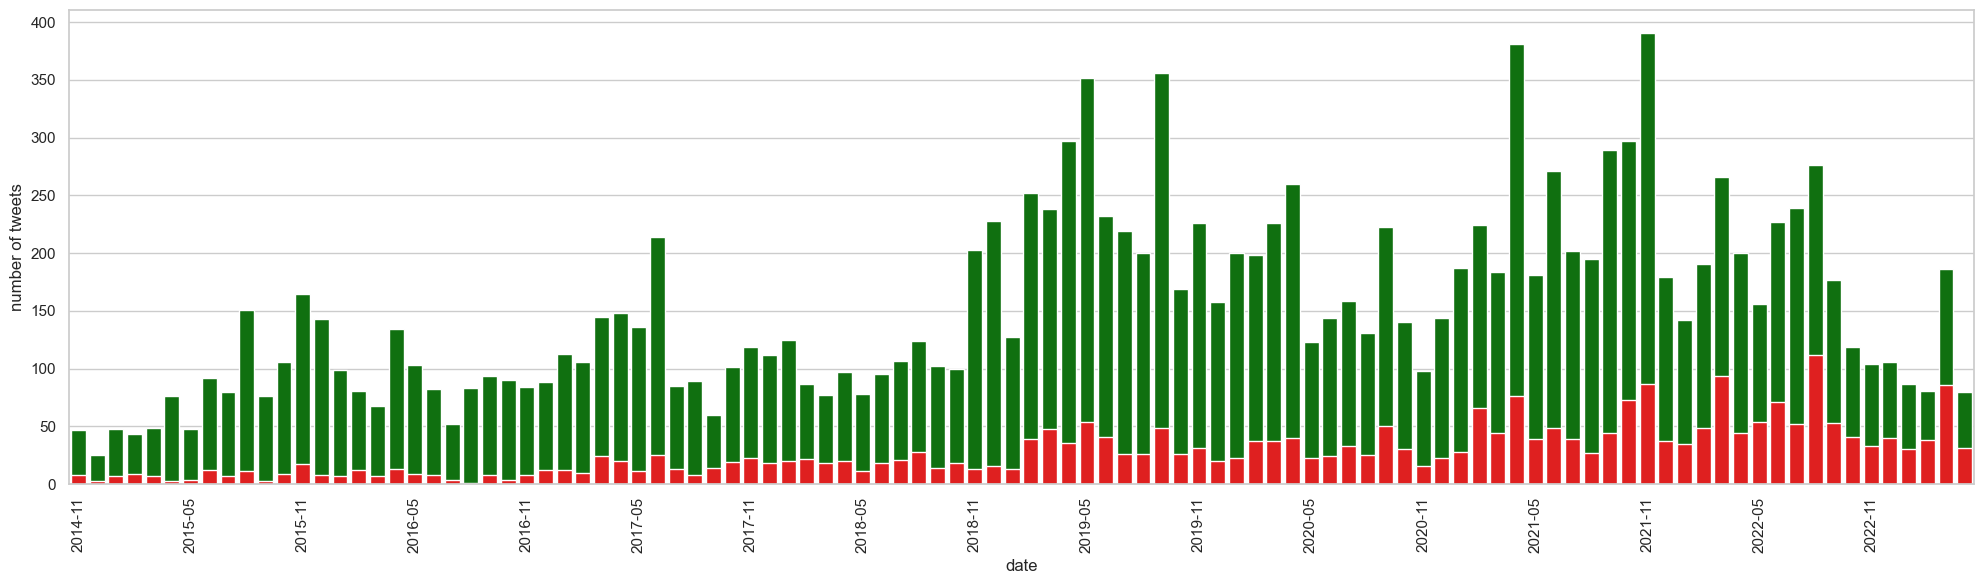

In [91]:
plt.figure(figsize=(20, 6))

#bar1 = sns.barplot(x="date",  y="total_tweets", data=micro_analysis_panel_full, color='lightgrey')
bar2 = sns.barplot(x="date",  y="climate_related_tweets", data=micro_analysis_panel_full, color='green')
bar3 = sns.barplot(x="date",  y="downplaying_tweets", data=micro_analysis_panel_full, color='red')


bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)
bar3.set_ylabel("number of tweets")

for ind, label in enumerate(bar3.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()

In [94]:
plt.figure(figsize=(12, 5))

#bar1 = sns.barplot(x="date_full",  y="total_tweets", data=micro_analysis_panel_full, color='lightgrey')
bar2 = sns.lineplot(x="date_full",  y="climate_ratio", data=micro_analysis_panel_full, color='green')
bar3 = sns.lineplot(x="date_full",  y="downplaying_ratio", data=micro_analysis_panel_full, color='red')
bar3 = sns.lineplot(x="date_full",  y="net_proclim_twt_rate_hemmi", data=micro_analysis_panel_full, color='blue')



#bar2.set_xticklabels(bar2.get_xticklabels(), rotation=90)
bar2.set_ylabel("ratios / rate")
bar2.set_xlabel("year")


bar2.set_xlim([pd.to_datetime(plot_politicians_with_trump_tweets_data.first_tweet.max()), pd.to_datetime("2023-04-30")])
#for ind, label in enumerate(bar2.get_xticklabels()):
#    if ind % 6 == 0:  # every 10th label is kept
#        label.set_visible(True)
#    else:
#        label.set_visible(False)

#plt.axvline(pd.to_datetime(cop_dates[(~cop_dates['COP_name'].isna())&(pd.to_datetime(cop_dates['date'])>=pd.to_datetime("2012-01-01"))]['date'].reset_index(drop=True)).values)

#plt.axvline(cop_dates[~cop_dates['COP_name'].isna()]['date'])

for date in pd.to_datetime(cop_dates[(cop_dates["COP_indicator"]==1)&(pd.to_datetime(cop_dates['date'])>=pd.to_datetime("2012-01-01"))]['date'].reset_index(drop=True)).values:
    plt.axvline(x=date, color = "lightblue", alpha = 1)



plt.tight_layout()

KeyError: 'party'

<Figure size 1200x500 with 0 Axes>

In [93]:
# politician level data
micro_analysis_panel = politicians_with_trump_tweets_data.groupby([pd.to_datetime(politicians_with_trump_tweets_data['date']).dt.to_period("M"),"name"]).agg(
    total_tweets = ('cleaned_text','count'),
    climate_related_tweets = ('climate_related_pred','sum'),
    downplaying_tweets = ('downplaying_pred', 'sum')
).reset_index()

micro_analysis_panel['climate_ratio'] = micro_analysis_panel['climate_related_tweets'] / micro_analysis_panel['total_tweets']
micro_analysis_panel['downplaying_ratio'] = micro_analysis_panel['downplaying_tweets'] / micro_analysis_panel['climate_related_tweets']
micro_analysis_panel['downplaying_ratio'].fillna(0, inplace=True)

micro_analysis_panel['date_full'] = micro_analysis_panel['date'].dt.to_timestamp()

micro_analysis_panel['party'] = micro_analysis_panel['name'].map(party_mapping)


In [94]:
micro_analysis_panel['name'].unique()

array(['Al Gore', 'Ami Bera, M.D.', 'Ann McLane Kuster',
       'Archive: Rep. Cheri Bustos', 'Barack Obama', 'Bernie Sanders',
       "Beto O'Rourke", 'Bruce Westerman', 'Congressman Bill Keating',
       'Congresswoman Chellie Pingree 🇺🇸 🇺🇦', 'David Cicilline',
       'Denny Heck', 'Donald Trump', 'Dr. Roger Marshall',
       'Elise Stefanik', 'Hakeem Jeffries', 'Jackie Speier',
       'James E. Clyburn', 'Jeff Fortenberry', 'Judy Chu',
       'Katherine Clark', 'Kevin McCarthy', 'Kyrsten Sinema',
       'Martin Heinrich', 'Mike Doyle', 'Mike Quigley', 'Paul Tonko',
       'Pete Sessions', 'Rep. Andy Barr', 'Rep. Andy Harris, MD',
       'Rep. Bill Huizenga', 'Rep. Bill Johnson', 'Rep. Frederica Wilson',
       'Rep. Henry Cuellar', 'Rep. John Sarbanes', 'Rep. Lloyd Smucker',
       'Rep. Paul Gosar, DDS', 'Rep. Scott Peters',
       'Rep. Stacey Plaskett', 'Robin Kelly', 'Sen. James Lankford',
       'Sen. Kevin Cramer', 'Senator Joe Manchin', 'Senator John Hoeven',
       'Senator 

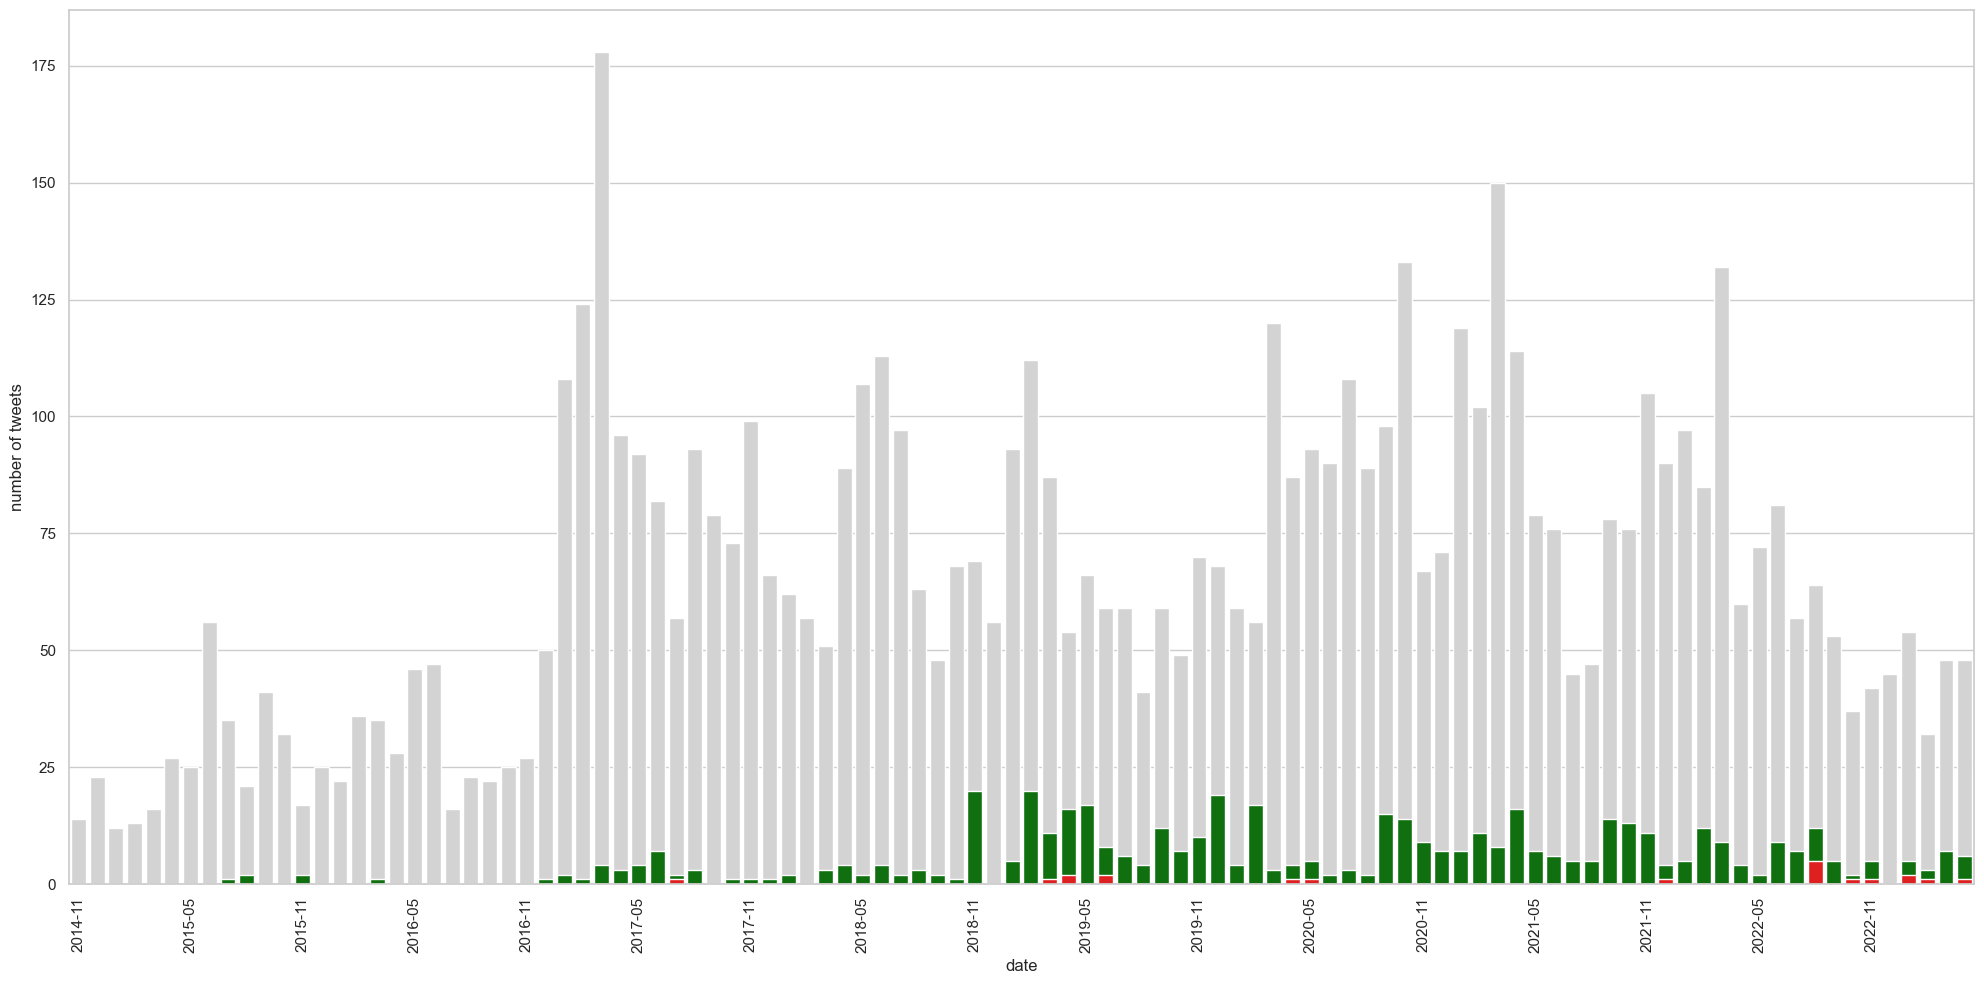

In [95]:
plt.figure(figsize=(20, 10))

politician_selected = "Congresswoman Chellie Pingree 🇺🇸 🇺🇦"

bar1 = sns.barplot(x="date",  y="total_tweets", data=micro_analysis_panel[micro_analysis_panel['name']==politician_selected], color='lightgrey')
bar2 = sns.barplot(x="date",  y="climate_related_tweets", data=micro_analysis_panel[micro_analysis_panel['name']==politician_selected], color='green')
bar3 = sns.barplot(x="date",  y="downplaying_tweets", data=micro_analysis_panel[micro_analysis_panel['name']==politician_selected], color='red')

bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)
bar3.set_ylabel("number of tweets")

for ind, label in enumerate(bar3.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()

ngram analysis

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

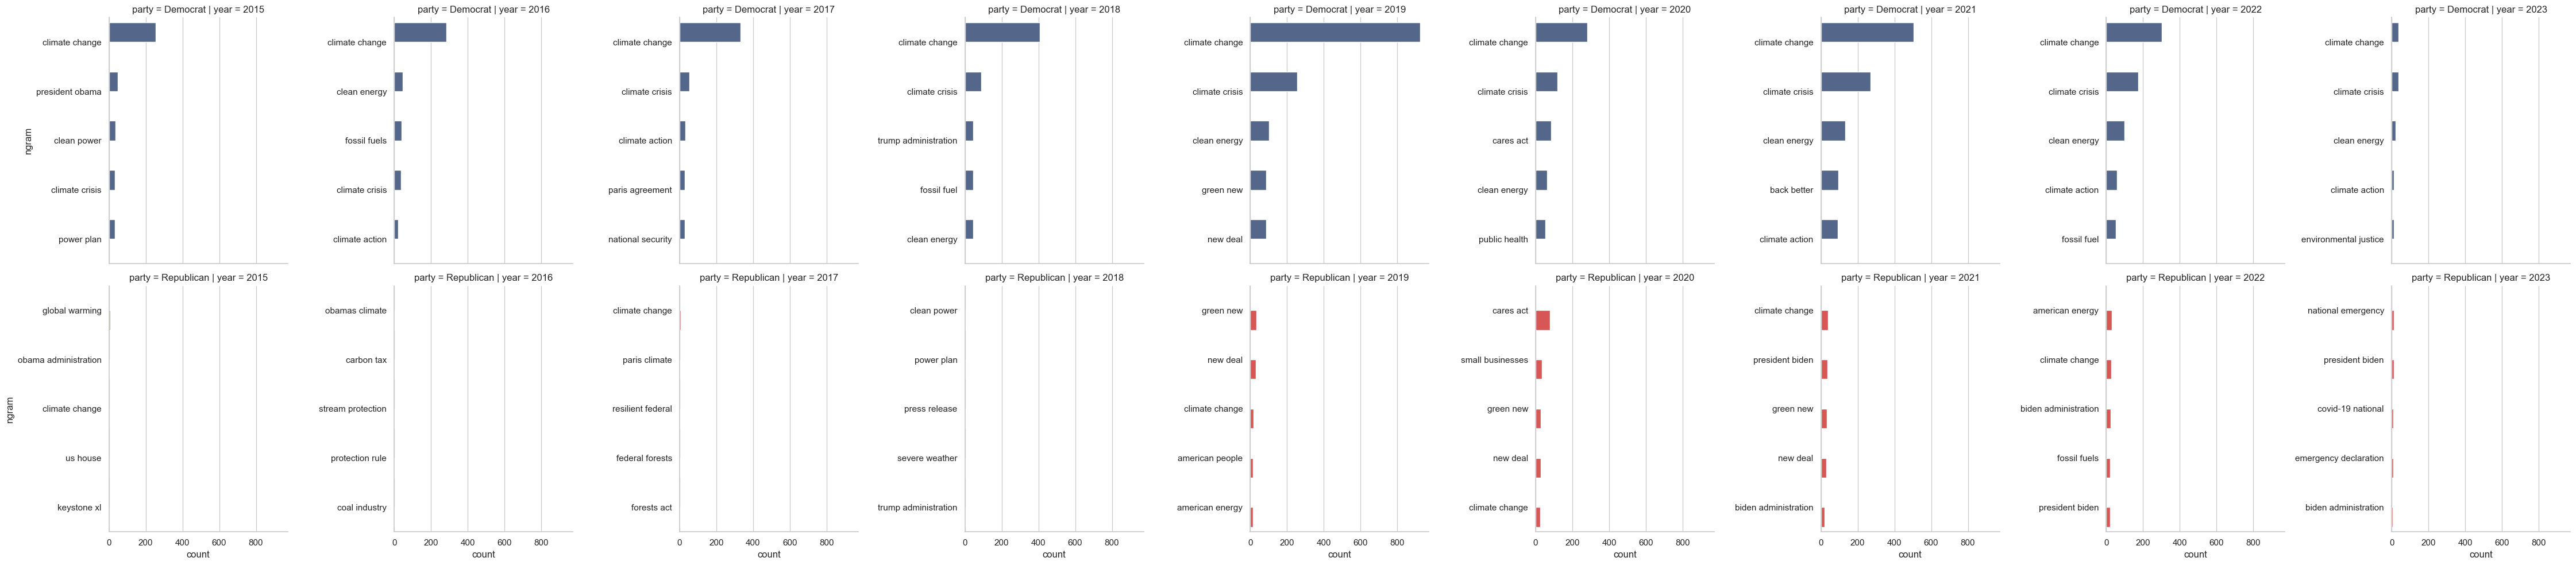

In [155]:
# create list of years and parties to plot
year_plots = [
              #2011,
              #2012,
              #2013,
              #2014,
              2015,
              2016,
              2017, 
              2018, 
              2019,
              2020,
              2021,
              2022,
              2023,
              ]

party_plots = ["Democrat", 
               "Republican",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get ngram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_with_trump_tweets_data['bigram_text'][(politicians_with_trump_tweets_data['climate_related_pred'] == 1) & 
                                                              (politicians_with_trump_tweets_data['downplaying_pred'] == 0) &
                                                              (politicians_with_trump_tweets_data['year'] == year_plot) &
                                                              (politicians_with_trump_tweets_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = cols, 
            sharey=False, 
            sharex = True,
        )
        

# for ax in g.axes.flatten():
#     ax.get_yaxis().set_label_coords(-1,0.5)

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

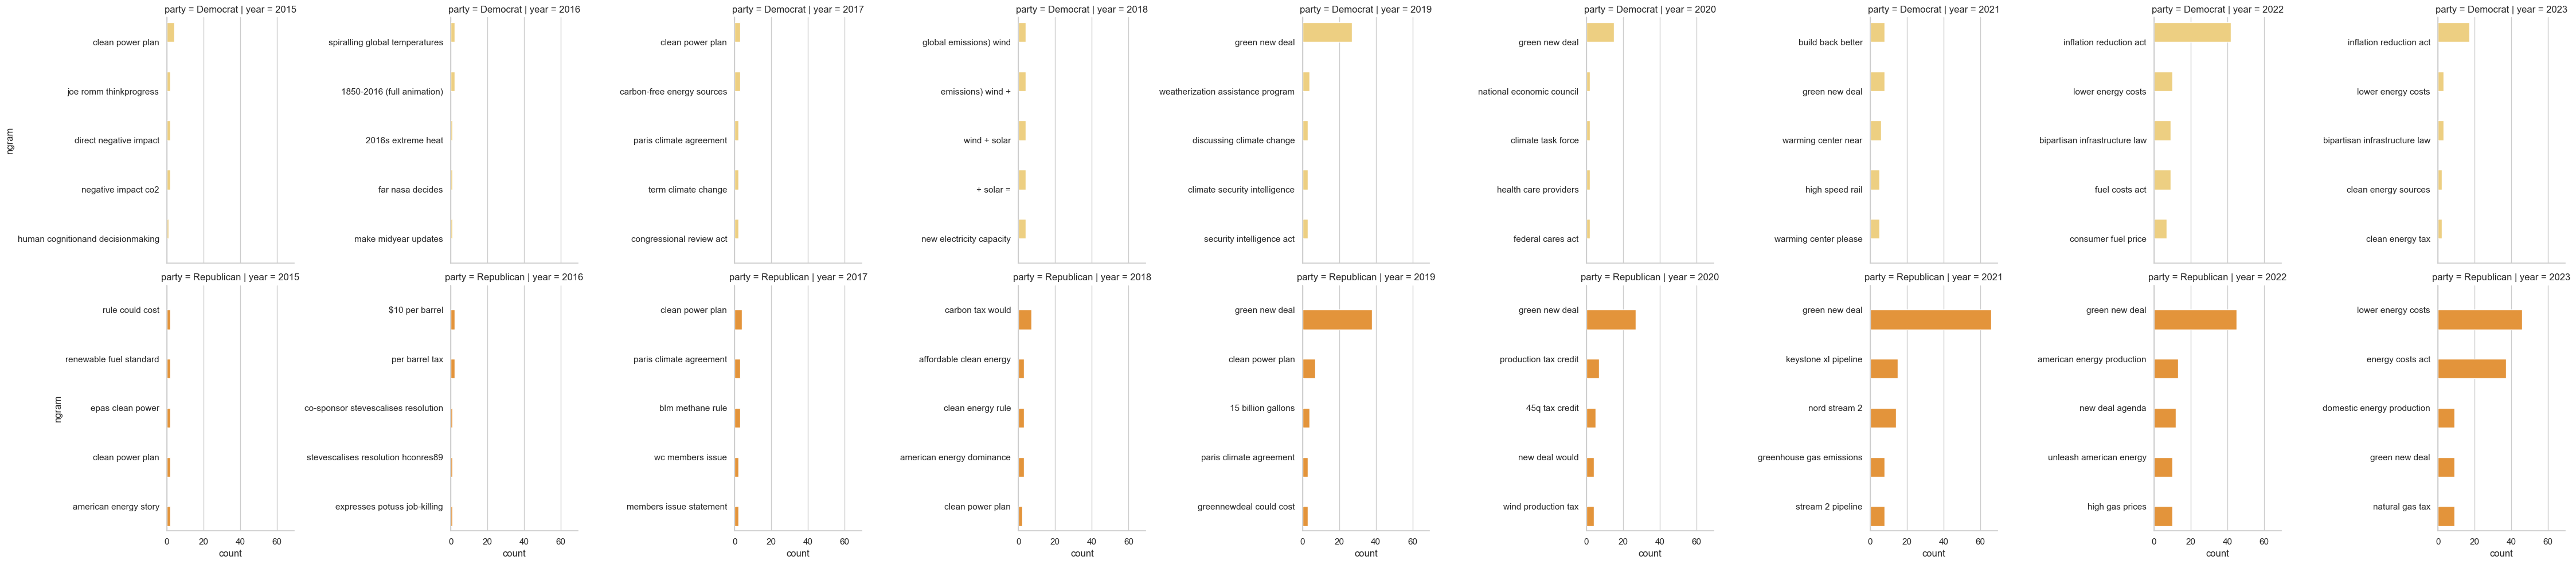

In [97]:
# create list of years and parties to plot
year_plots = [
              #2011,
              #2012,
              #2013,
              #2014,
              2015,
              2016,
              2017, 
              2018, 
              2019,
              2020,
              2021,
              2022,
              2023,
              ]

party_plots = ["Democrat", 
               "Republican",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get ngram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_with_trump_tweets_data['trigram_text'][(politicians_with_trump_tweets_data['climate_related_pred'] == 1) & 
                                                              (politicians_with_trump_tweets_data['downplaying_pred'] == 1) &
                                                              (politicians_with_trump_tweets_data['year'] == year_plot) &
                                                              (politicians_with_trump_tweets_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = cols_downplaying, 
            sharey=False, 
            sharex = True,
        )
        

# for ax in g.axes.flatten():
#     ax.get_yaxis().set_label_coords(-1,0.5)

plt.tight_layout

scatter plots

In [98]:
#plot_politicians_with_trump_tweets_data['name'].map(age_mapping)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


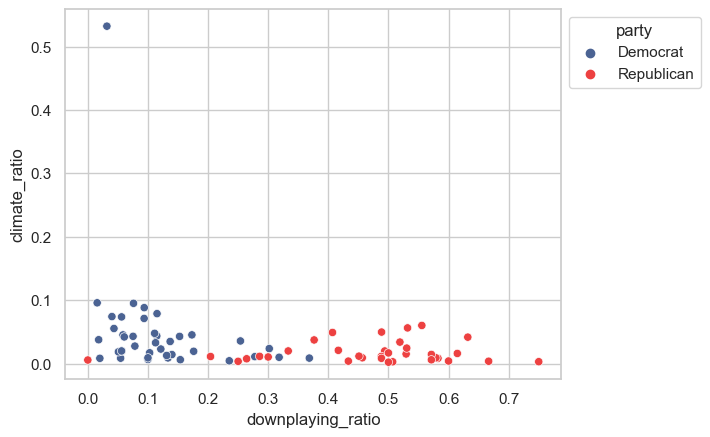

In [99]:


plot = sns.scatterplot(data = plot_politicians_with_trump_tweets_data,
                x = "downplaying_ratio",
                y = "climate_ratio" ,
                hue = "party",
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


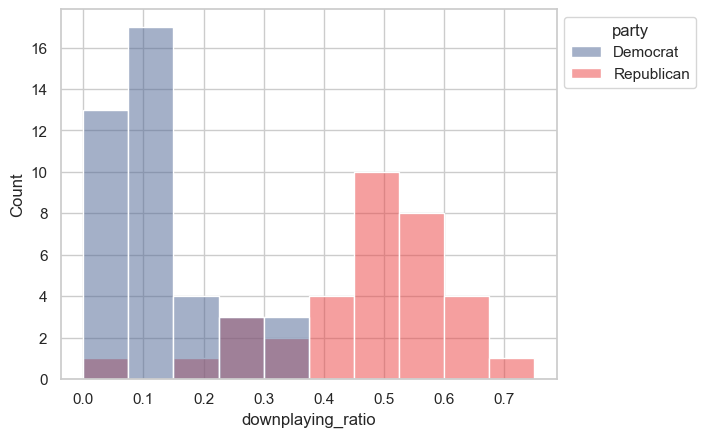

In [100]:
plot = sns.histplot(data = plot_politicians_with_trump_tweets_data,
                #x = "downplaying_ratio",
                x = "downplaying_ratio" ,
                hue = "party",
                bins = 10,
                palette=cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

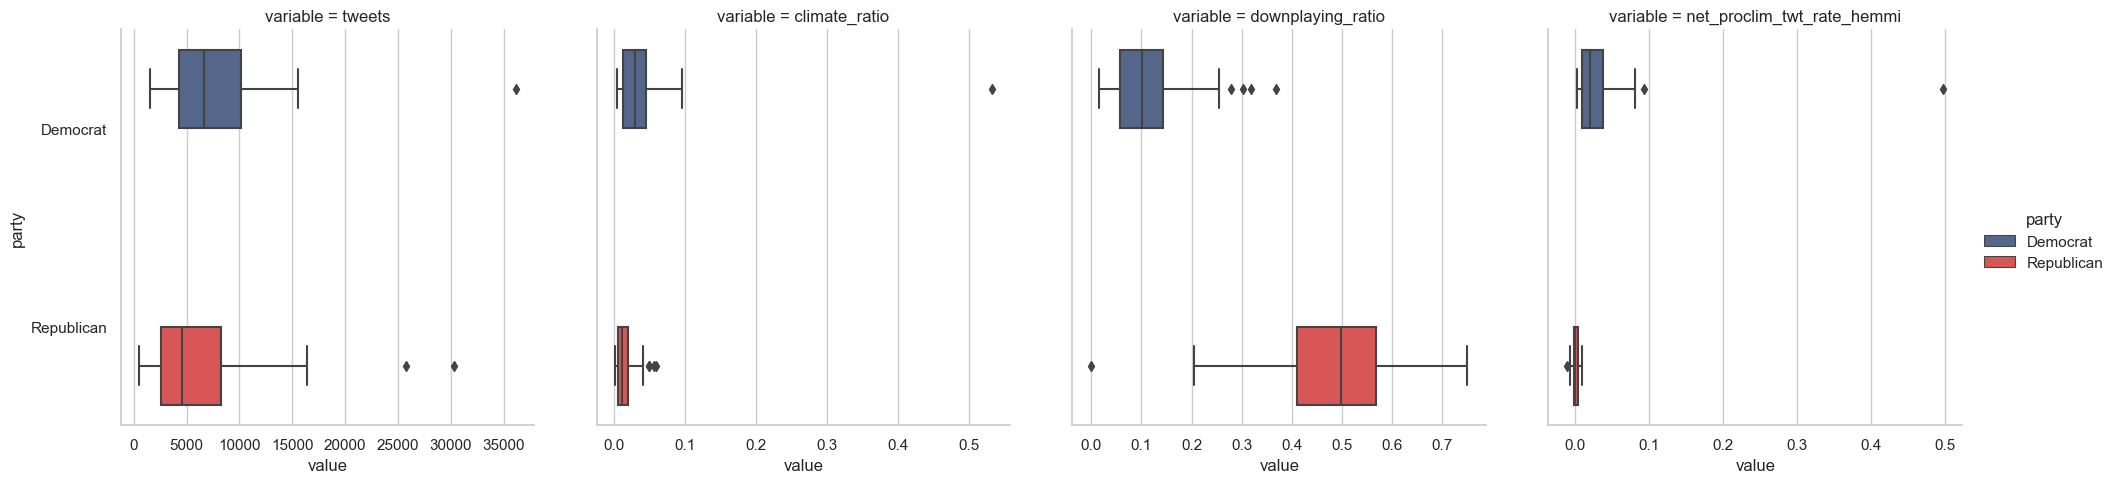

In [101]:
sns.set_style("whitegrid")

g = sns.catplot(
            x='value', 
            y='party', 
            col = "variable", 
            #row = "party", 
            data= plot_politicians_with_trump_tweets_data[["party","name","tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].melt(id_vars=["party","name"]), 
            kind="box", 
            hue = "party", 
            palette = cols, 
            sharey=True, 
            sharex = False,
        )

plt.subplots_adjust(wspace=0.15)
#plt.tight_layout()

In [102]:
plot_politicians_with_trump_tweets_data[["party","name","tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].groupby("party").agg(
    n_politicians = ("name", "count"),
    mean_total_tweet = ("tweets", lambda x: round(np.mean(x),2)),
    mean_climate_ratio = ("climate_ratio", lambda x: round(np.mean(x),2)),
    mean_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.mean(x),2)),
    mean_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.mean(x),2)),
    
    median_total_tweet = ("tweets", lambda x: round(np.median(x),2)),
    median_climate_ratio = ("climate_ratio", lambda x: round(np.median(x),2)),
    median_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.median(x),2)),
    median_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.median(x),2)),
)

,n_politicians,mean_total_tweet,mean_climate_ratio,mean_downplaying_ratio,mean_proclimate_twt_rate,median_total_tweet,median_climate_ratio,median_downplaying_ratio,median_proclimate_twt_rate
party,,,,,,,,,
Democrat,40,7918.02,0.05,0.12,0.04,6697.0,0.03,0.1,0.02
Republican,34,6859.21,0.02,0.47,0.00,4575.5,0.01,0.5,0.00


panel data format

In [103]:
# turning the data into panel format

In [104]:
follower_count_selected_politicians['date'] = pd.to_datetime(follower_count_selected_politicians.date).dt.to_period("M")

In [105]:
temp_df = pd.merge(micro_analysis_panel, follower_count_selected_politicians,
        left_on = ["date","name"],
        right_on = ["date","author.name"],
        how = "left")

micro_analysis_panel['followers'] = temp_df['author.public_metrics.followers_count']

# adding trumps followers (constant value since his account is not accessible through twarc)
micro_analysis_panel['followers'].fillna(87100000, inplace= True)

In [106]:
micro_analysis_panel['birth_year'] = micro_analysis_panel['name'].map(age_mapping)

In [107]:
micro_analysis_panel['year'] = micro_analysis_panel['date_full'].dt.year

In [108]:
micro_analysis_panel['age'] = micro_analysis_panel['year'] - micro_analysis_panel['birth_year']

In [109]:
cop_dates['date_month'] = pd.to_datetime(cop_dates['date'],format="%d.%m.%Y").dt.to_period("M")

In [110]:
temp_df= pd.merge(micro_analysis_panel,cop_dates,
                  how = "left",
                  left_on = "date",
                  right_on = "date_month")

micro_analysis_panel['COP_indicator'] = temp_df['COP_indicator']
micro_analysis_panel['COP_before_indicator'] = temp_df['COP_before_indicator']
micro_analysis_panel['COP_after_indicator'] = temp_df['COP_after_indicator']
micro_analysis_panel['COP_name'] = temp_df['COP_name']
micro_analysis_panel['paris_indicator'] = temp_df['paris_indicator']
micro_analysis_panel['paris_event_name'] = temp_df['paris_event_name']

In [111]:
summary_stats_us_politicians_na_filtered.region = summary_stats_us_politicians_na_filtered.region.str.strip()

### Outputs for linear regressions and panel regressions

In [112]:
micro_analysis_panel.to_csv("./panel_regression/selected_politicians_panel_data.csv", sep = ";")

In [113]:
summary_stats_us_politicians_na_filtered.to_csv("./panel_regression/us_politicians_data.csv", sep = ";")

## Summary Statistics UK

In [114]:
uk_politicians_follower_count['date'] = pd.to_datetime(uk_politicians_follower_count.date).dt.to_period("M")

temp_df = pd.merge(politicians_uk_data,uk_politicians_follower_count,
         left_on = [pd.to_datetime(politicians_uk_data.date).dt.to_period("M"),"name"],
         right_on = ["date","name"],
         how = "left")


politicians_uk_data['followers'] = temp_df['user_followers_count']


In [115]:
summary_politicians_uk_data = politicians_uk_data.groupby("party").agg(
    n = ("name","nunique"),
    tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
    min_n_words = ("cleaned_text_word_count", "min"),
    max_n_words = ("cleaned_text_word_count", "max"),
    mean_n_words = ("cleaned_text_word_count", lambda x: round(x.mean())),
    mean_followers = ("followers", lambda x: round(x.mean())),
    median_followers = ("followers", lambda x: round(x.median())),
    first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
    last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
).sort_values("tweets",ascending=False).reset_index()


summary_politicians_uk_data['climate_ratio'] = summary_politicians_uk_data['climate_tweets']/summary_politicians_uk_data['tweets']
summary_politicians_uk_data['downplaying_ratio'] = summary_politicians_uk_data['downplaying_tweets']/summary_politicians_uk_data['climate_tweets']

summary_politicians_uk_data

,party,n,tweets,climate_tweets,downplaying_tweets,min_n_words,max_n_words,mean_n_words,mean_followers,median_followers,first_tweet,last_tweet,climate_ratio,downplaying_ratio
0,Labour,220,589539,7274,622.0,4,101,27,102735,33991,05-2017,08-2021,0.012338,0.085510
1,Conservative,345,417694,7174,830.0,4,103,27,75866,24931,05-2017,08-2021,0.017175,0.115696
2,Scottish National Party,45,181609,1408,161.0,4,107,27,36368,26594,05-2017,08-2021,0.007753,0.114347
3,Labour Co-op,38,147836,1915,160.0,4,100,27,43070,37135,05-2017,08-2021,0.012954,0.083551
4,Liberal Democrat,15,28960,516,34.0,4,99,28,87104,47711,06-2017,08-2021,0.017818,0.065891
5,Sinn Féin,8,14119,41,3.0,4,68,28,19497,21880,06-2017,08-2021,0.002904,0.073171
6,Plaid Cymru,3,10170,89,9.0,4,63,28,16265,10683,06-2017,08-2021,0.008751,0.101124
7,Democratic Unionist Party,9,5610,27,11.0,4,66,29,22745,19683,06-2017,08-2021,0.004813,0.407407
8,Independent,3,4318,8,1.0,4,58,25,31044,38145,06-2017,08-2021,0.001853,0.125000
9,Green Party,1,4267,715,39.0,4,58,33,616420,616060,06-2017,08-2021,0.167565,0.054545


In [116]:
monthly_aggregated_uk_politicians_stats_party_split = politicians_uk_data.groupby([pd.to_datetime(politicians_uk_data['date']).dt.to_period(freq="M"),"party"]).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

In [117]:
# filtering for the two main parties
monthly_aggregated_uk_politicians_stats_party_split = monthly_aggregated_uk_politicians_stats_party_split[monthly_aggregated_uk_politicians_stats_party_split['party'].isin(["Conservative","Labour"])]

In [118]:
full_date_series = pd.DataFrame(pd.date_range(start="2017.05.01", end = "2021.08.01", freq="M").to_period("M")).reset_index().rename(columns={0:"date"})
full_monthly_aggregated_uk_politicians_stats_party_split = pd.merge(full_date_series,monthly_aggregated_uk_politicians_stats_party_split,
            on = "date",
            how = "left")

In [119]:
uk_cols = {
    'Labour':"#F24052", 
    'Conservative':"#2B3F8C"
    }


uk_cols_climate = {
    'Labour':"#BED45E", 
    'Conservative':"#6BC776"
    }


uk_cols_downplaying = {
    'Labour':"#F8E5A0", 
    'Conservative':"#EFC52E"
    }

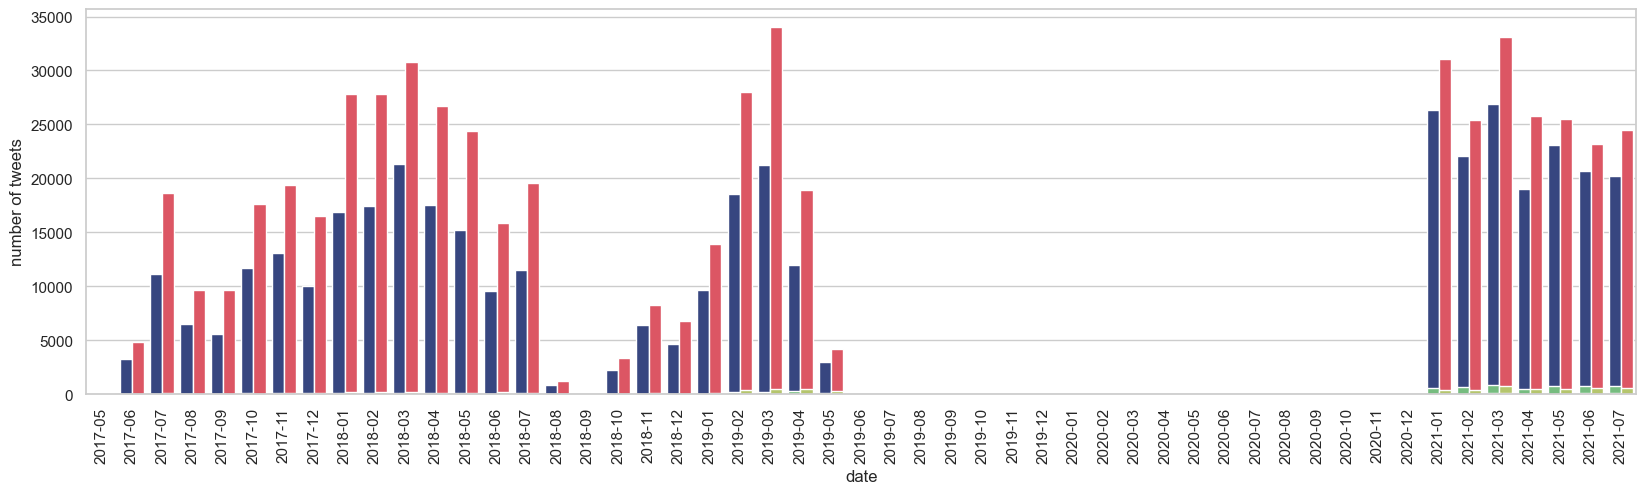

In [120]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="whitegrid")

bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_uk_politicians_stats_party_split, hue = "party", palette=uk_cols)

bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_uk_politicians_stats_party_split, hue = "party", palette=uk_cols_climate, )

bar3 = sns.barplot(x="date",  y="downplaying_tweets", data=full_monthly_aggregated_uk_politicians_stats_party_split, hue = "party", palette=uk_cols_downplaying, )


bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)
bar3.set_ylabel("number of tweets")


plt.legend([],[], frameon=False)

In [121]:
monthly_aggregated_uk_politicians_stats_full = politicians_uk_data.groupby(pd.to_datetime(politicians_uk_data['date']).dt.to_period(freq="M")).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

monthly_aggregated_uk_politicians_stats_full['climate_ratio'] = monthly_aggregated_uk_politicians_stats_full['climate_tweets'] / monthly_aggregated_uk_politicians_stats_full['total_tweets']


monthly_aggregated_uk_politicians_stats_full.head(6)

,date,total_tweets,climate_tweets,downplaying_tweets,climate_ratio
0,2017-05,187,0,0.0,0.000000
1,2017-06,10977,21,0.0,0.001913
2,2017-07,41006,158,19.0,0.003853
3,2017-08,23492,92,35.0,0.003916
4,2017-09,22002,73,11.0,0.003318
5,2017-10,41552,162,38.0,0.003899


In [122]:

full_monthly_aggregated_uk_politicians_stats_full = pd.merge(full_date_series,monthly_aggregated_uk_politicians_stats_full,
            on = "date",
            how = "left")

Text(0, 0.5, 'number of tweets')

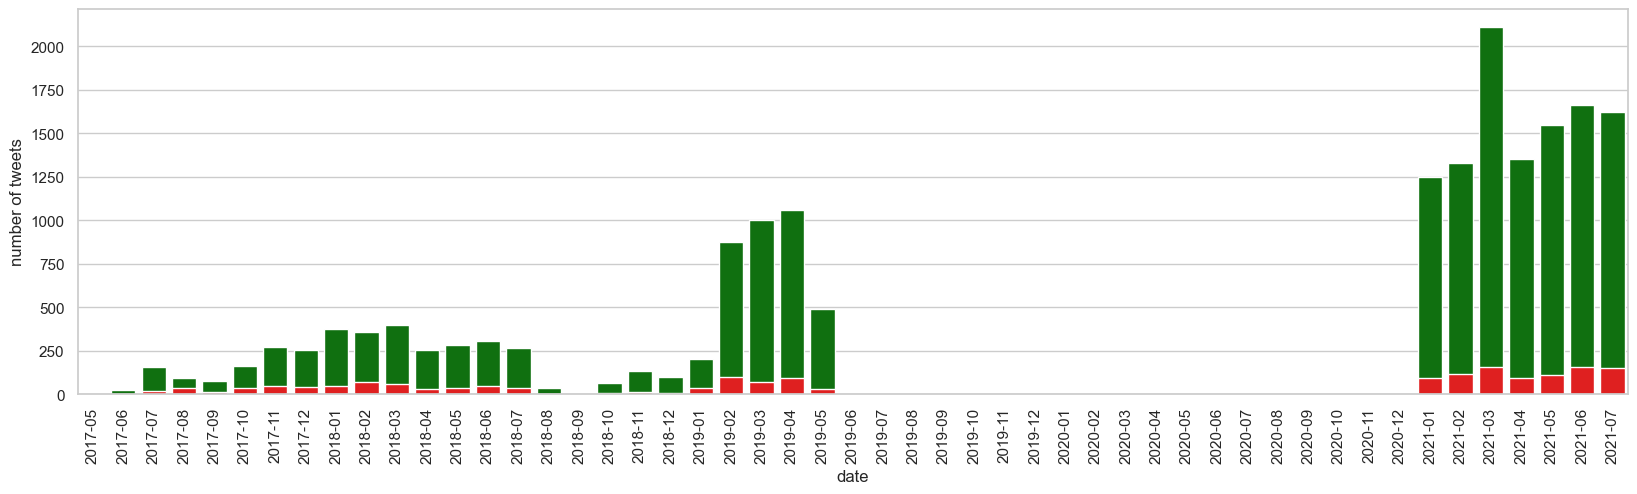

In [123]:
plt.figure(figsize=(20, 5))
#bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_uk_politicians_stats_full, color='grey')
bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_uk_politicians_stats_full, color='green')
bar3 = sns.barplot(x = "date", y= "downplaying_tweets", data=full_monthly_aggregated_uk_politicians_stats_full, color='red')

bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)

bar3.set_ylabel("number of tweets")


Text(0.5, 1.0, '2021 frequent trigrams Conservative')

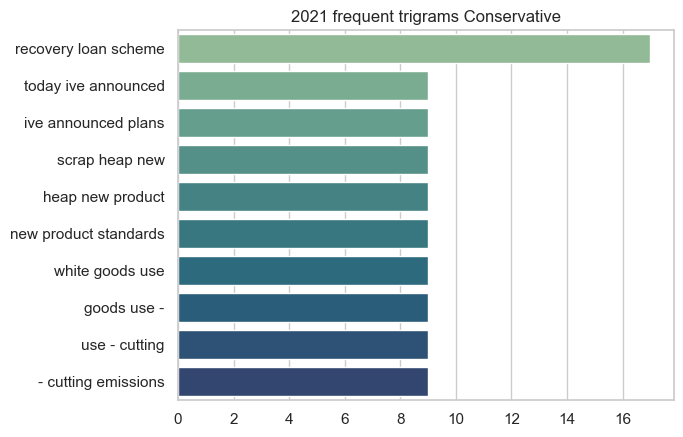

In [124]:
# plot the top n ngrams for each party and each year

year_plot = 2021
party_plot = "Conservative"
x,y=map(list,zip(*counter(politicians_uk_data['trigram_text'][(politicians_uk_data['climate_related_pred'] == 1) & 
                                                              (politicians_uk_data['downplaying_pred'] == 1) &
                                                              (politicians_uk_data['year'] == year_plot) &
                                                              (politicians_uk_data['party'] == party_plot)
                                                                            ]).most_common(10)))

# turn the tuples into a combined string
for i in range(len(x)):
    x[i] = ' '.join(x[i])

sns.barplot(x=y,y=x, palette="crest").set_title(str(year_plot) + " frequent trigrams "+ party_plot)

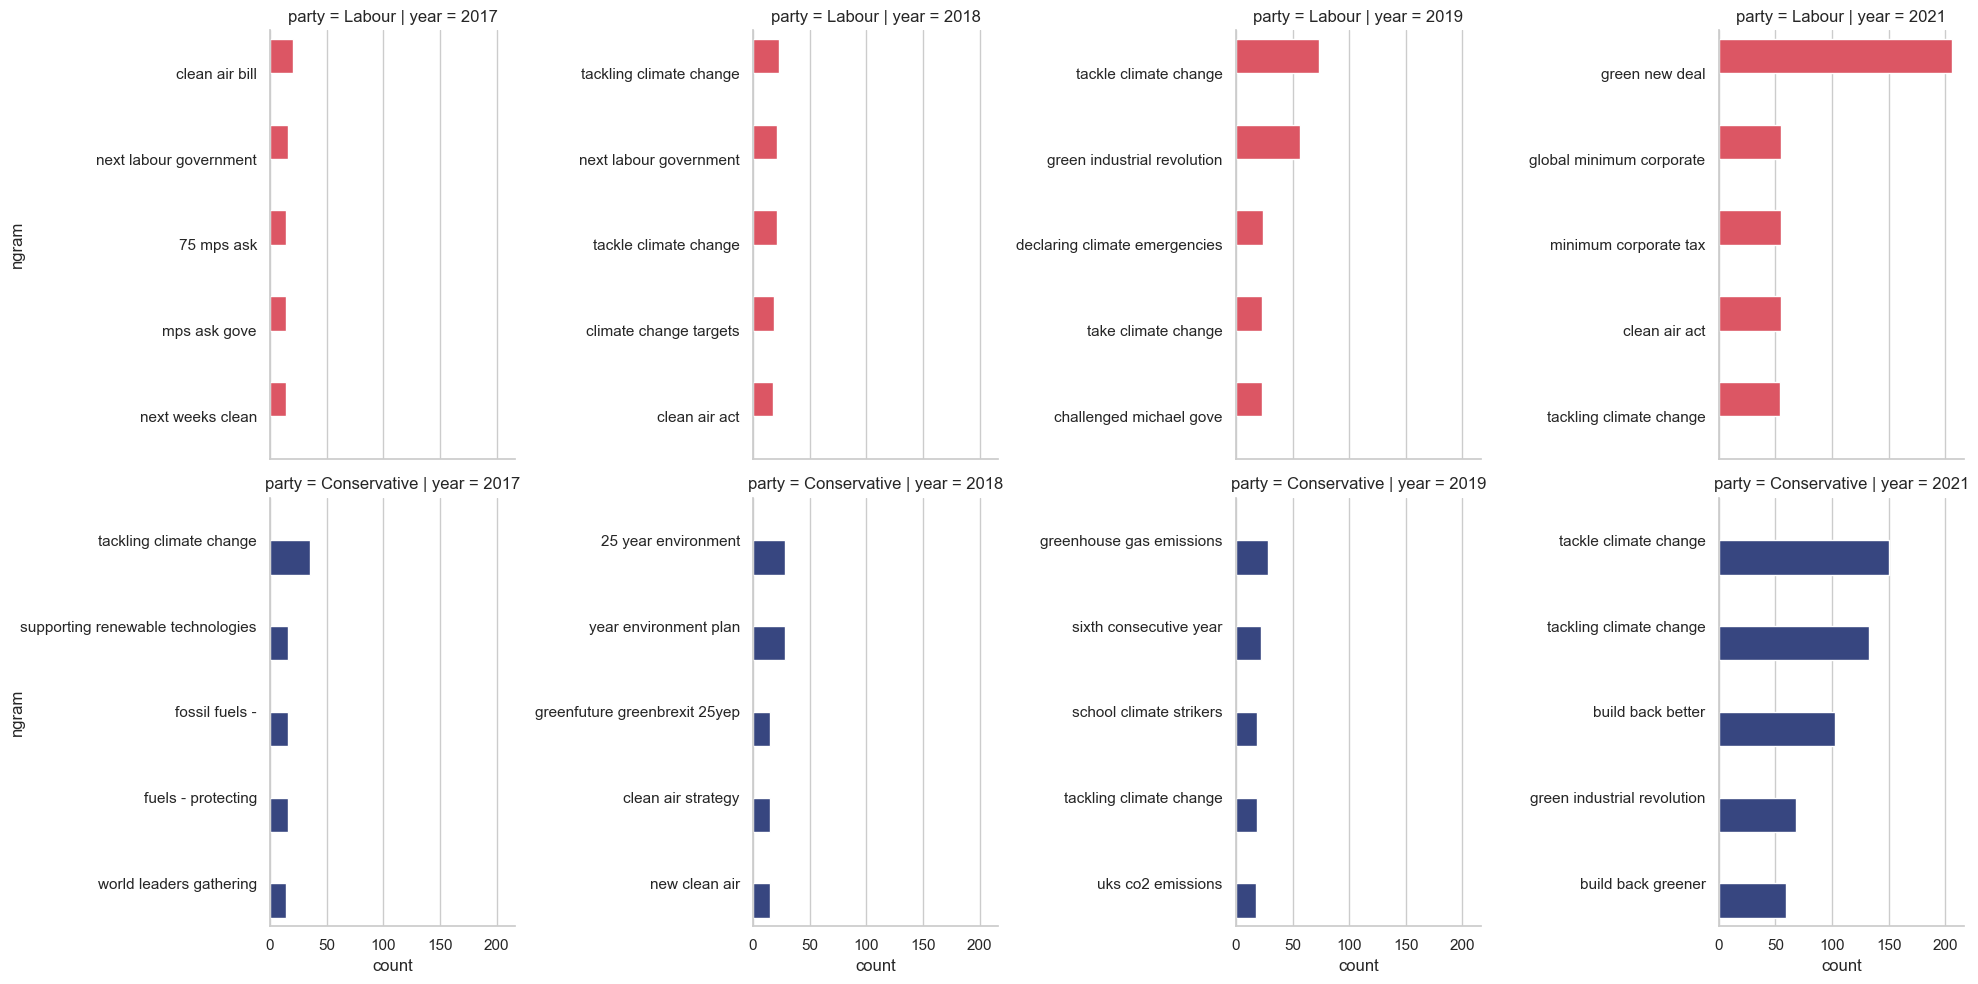

In [125]:
# create list of years and parties to plot
year_plots = [2017, 2018, 2019, 2021]
party_plots = ["Labour", 
               "Conservative",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get bigram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_uk_data['trigram_text'][(politicians_uk_data['climate_related_pred'] == 1) & 
                                                              (politicians_uk_data['downplaying_pred'] == 0) &
                                                              (politicians_uk_data['year'] == year_plot) &
                                                              (politicians_uk_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# create long dataframe
#df = pd.DataFrame(results)

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = uk_cols, 
            sharey=False, 
            sharex = True,
        )
        

for ax in g.axes.flatten():
    ax.get_yaxis().set_label_coords(-1,0.5)

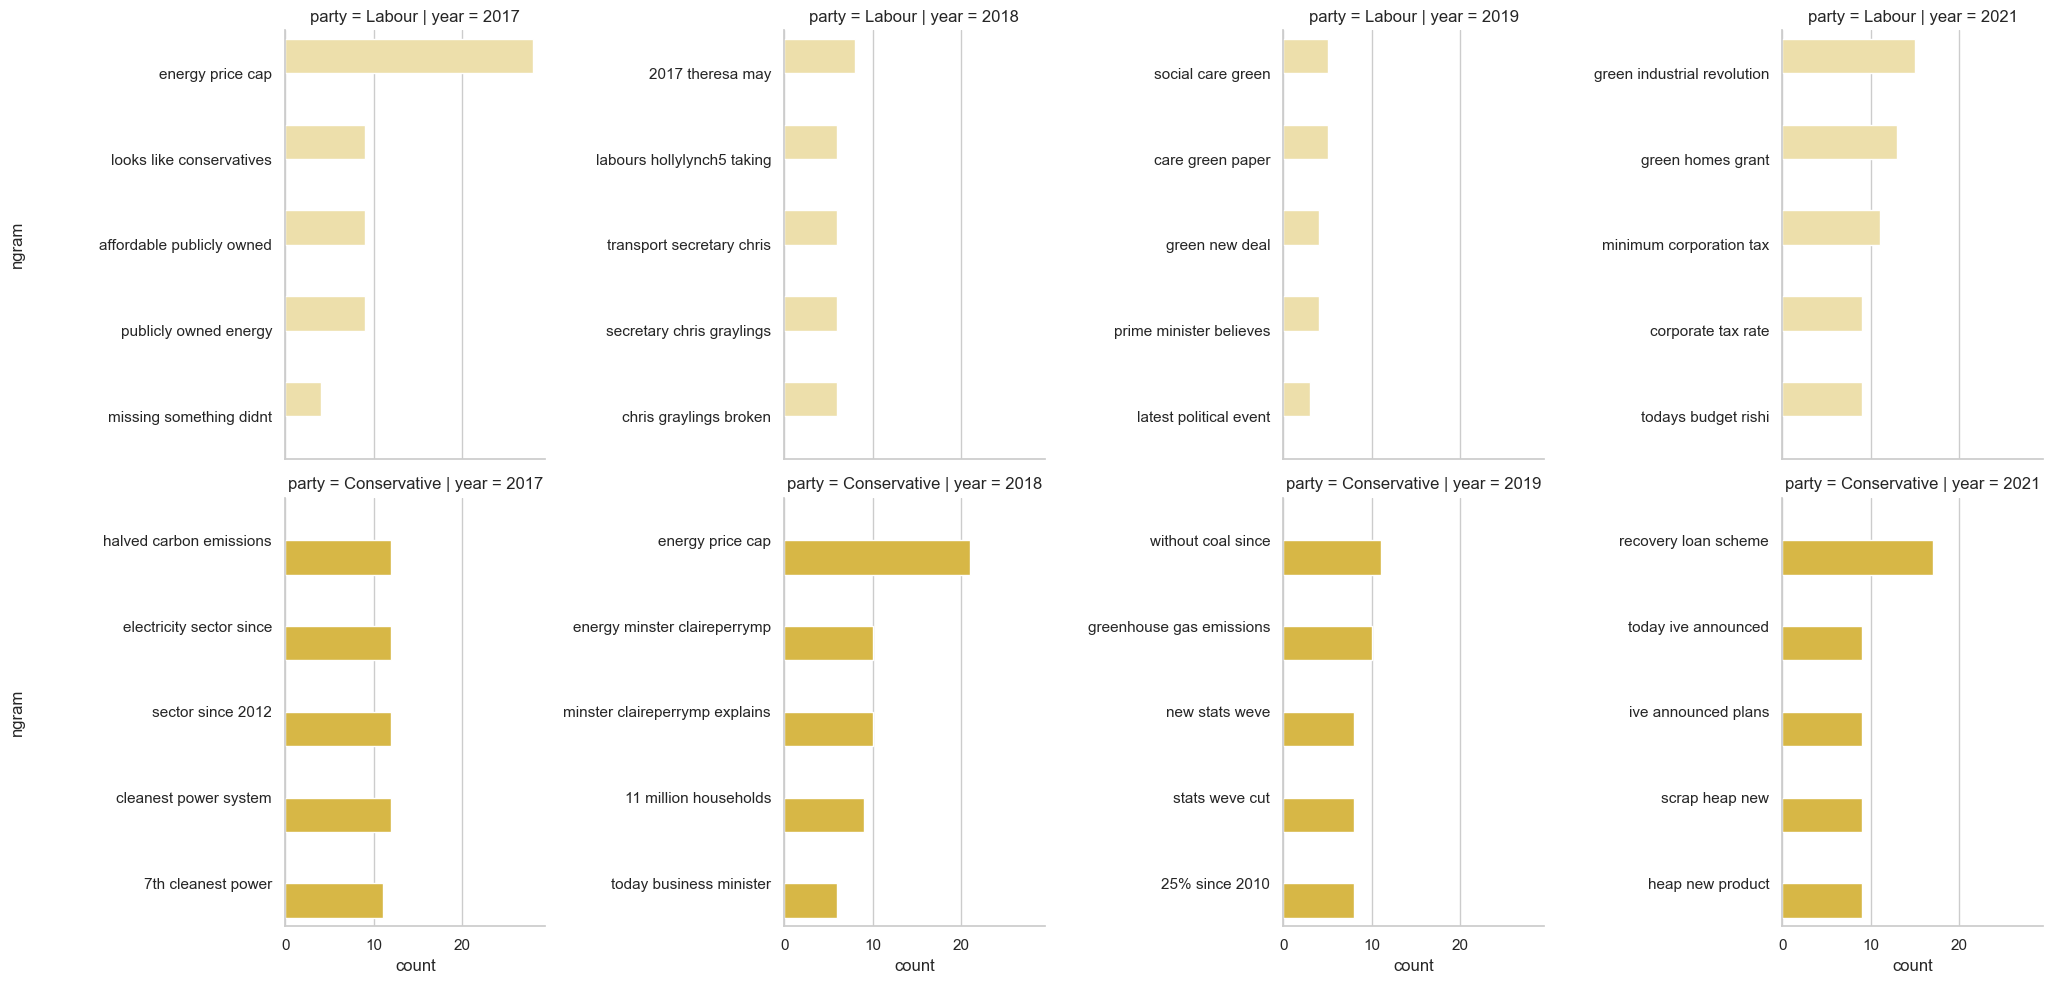

In [126]:
# create list of years and parties to plot
year_plots = [2017, 2018, 2019, 2021]
party_plots = ["Labour", 
               "Conservative",
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get bigram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_uk_data['trigram_text'][(politicians_uk_data['climate_related_pred'] == 1) & 
                                                              (politicians_uk_data['downplaying_pred'] == 1) &
                                                              (politicians_uk_data['year'] == year_plot) &
                                                              (politicians_uk_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# create long dataframe
#df = pd.DataFrame(results)

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = uk_cols_downplaying, 
            sharey=False, 
            sharex = True,
        )
        

for ax in g.axes.flatten():
    ax.get_yaxis().set_label_coords(-1,0.5)


#plt.tight_layout()

In [127]:
summary_stats_uk_politicians = politicians_uk_data.groupby("name").agg(
    
    party = ('party', lambda x: x.unique()[0]),

    first_tweet = ('date', lambda x: pd.to_datetime(x).min()),

    last_tweet = ('date', lambda x: pd.to_datetime(x).max()),

    total_tweets = ('cleaned_text', 'count'),

    mean_followers = ("followers", lambda x: x.mean().round(1)),

    climate_related =('climate_related_pred', sum),
    
    downplaying=('downplaying_pred', sum),

)

summary_stats_uk_politicians['climate_ratio'] = summary_stats_uk_politicians['climate_related'] / summary_stats_uk_politicians['total_tweets']
summary_stats_uk_politicians['downplaying_ratio'] = summary_stats_uk_politicians['downplaying'] / summary_stats_uk_politicians['climate_related']
summary_stats_uk_politicians['downplaying_ratio'] = summary_stats_uk_politicians['downplaying_ratio'].fillna(0)

summary_stats_uk_politicians['net_proclim_twt_rate_hemmi'] = ((summary_stats_uk_politicians['climate_related']-summary_stats_uk_politicians['downplaying'])-summary_stats_uk_politicians['downplaying'])/summary_stats_uk_politicians['total_tweets']

summary_stats_uk_politicians['underscoring_ratio'] = 1 - summary_stats_uk_politicians['downplaying_ratio']

summary_stats_uk_politicians.reset_index(inplace=True)

In [128]:
filtered_summary_stats_uk_politicians = summary_stats_uk_politicians[summary_stats_uk_politicians['party'].isin(["Labour","Conservative"])]

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


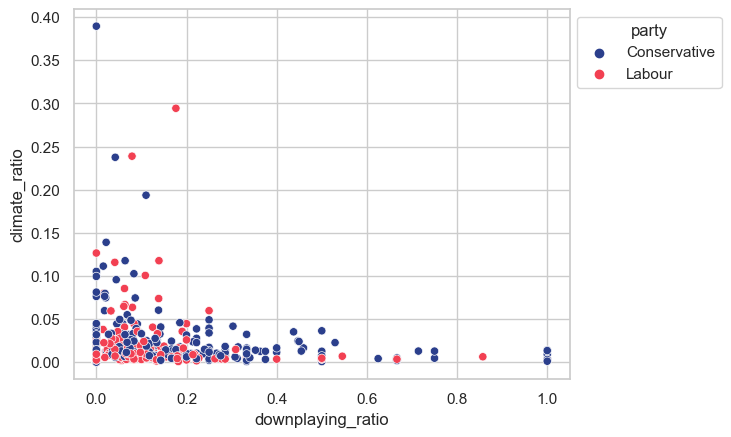

In [129]:
#sns.set_theme("whitegrid")

plot = sns.scatterplot(data = filtered_summary_stats_uk_politicians,
                x = "downplaying_ratio",
                y = "climate_ratio" ,
                hue = "party",
                #size = "mean_followers",
                palette=uk_cols)

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


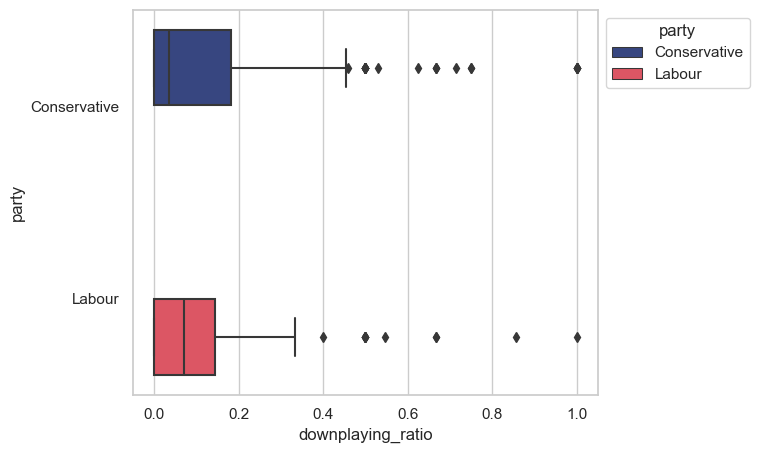

In [130]:
plt.figure(figsize=(6,5))

plot = sns.boxplot(data = filtered_summary_stats_uk_politicians,
                x = "downplaying_ratio",
                y = "party" ,
                hue = "party",
                palette=uk_cols
                )

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

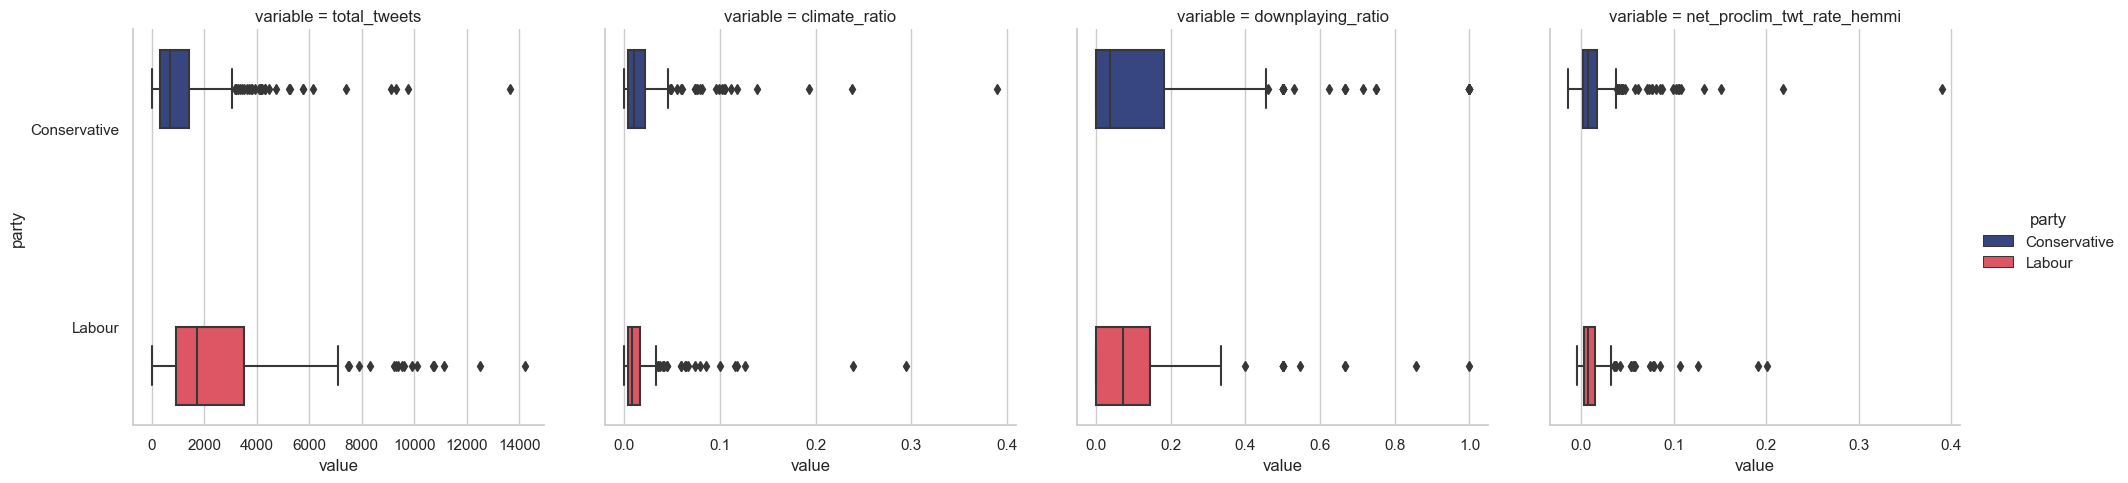

In [131]:
sns.set_style("whitegrid")

g = sns.catplot(
            x='value', 
            y='party', 
            col = "variable", 
            #row = "party", 
            data= filtered_summary_stats_uk_politicians[["party","name","total_tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].melt(id_vars=["party","name"]), 
            kind="box", 
            hue = "party", 
            palette = uk_cols, 
            sharey=True, 
            sharex = False,
        )

plt.subplots_adjust(wspace=0.15)
#plt.tight_layout()

In [132]:
filtered_summary_stats_uk_politicians[["party","name","total_tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].groupby("party").agg(
    n_politicians = ("name", "count"),
    mean_total_tweet = ("total_tweets", lambda x: round(np.mean(x),2)),
    mean_climate_ratio = ("climate_ratio", lambda x: round(np.mean(x),2)),
    mean_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.mean(x),2)),
    mean_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.mean(x),2)),
    
    median_total_tweet = ("total_tweets", lambda x: round(np.median(x),2)),
    median_climate_ratio = ("climate_ratio", lambda x: round(np.median(x),2)),
    median_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.median(x),2)),
    median_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.median(x),2)),
)

,n_politicians,mean_total_tweet,mean_climate_ratio,mean_downplaying_ratio,mean_proclimate_twt_rate,median_total_tweet,median_climate_ratio,median_downplaying_ratio,median_proclimate_twt_rate
party,,,,,,,,,
Conservative,345,1210.71,0.02,0.13,0.02,703.0,0.01,0.04,0.01
Labour,220,2679.72,0.02,0.11,0.01,1745.0,0.01,0.07,0.01


c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


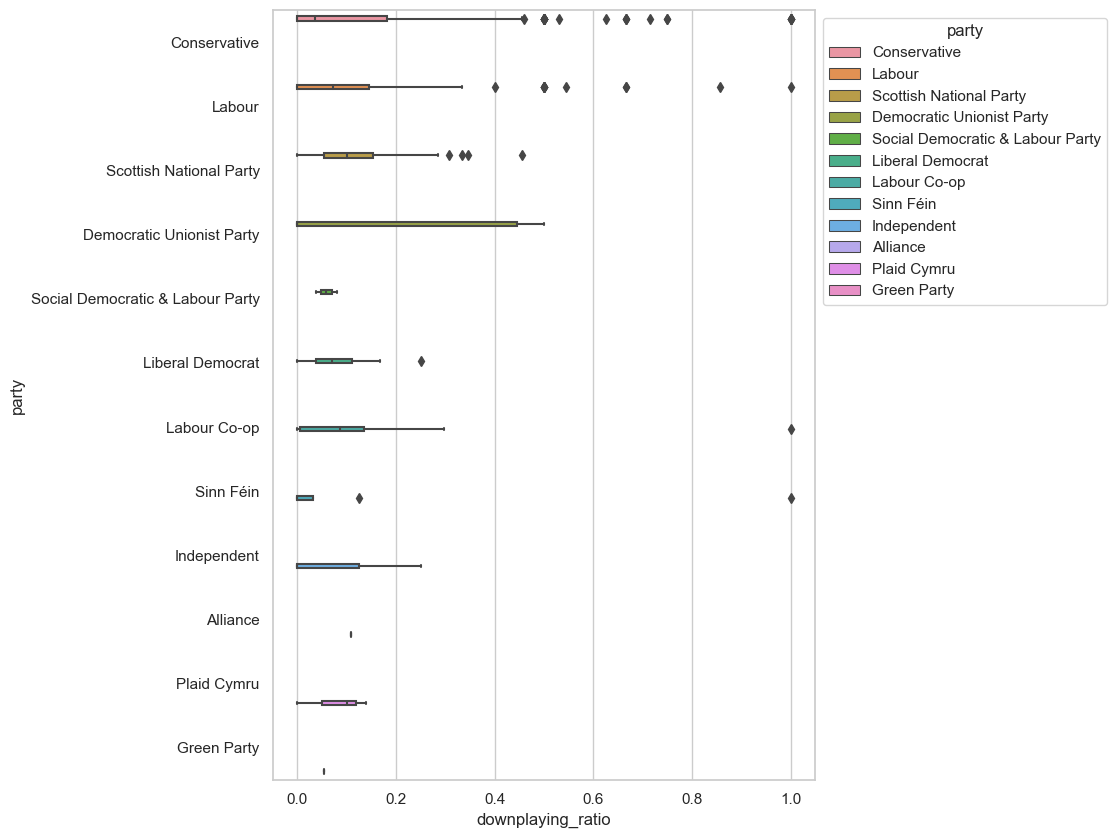

In [133]:
plt.figure(figsize=(7, 10))

plot = sns.boxplot(data = summary_stats_uk_politicians,
                x = "downplaying_ratio",
                y = "party" ,
                hue = "party",
                #palette=cols
                )

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

In [134]:
filtered_summary_stats_uk_politicians.to_csv("./panel_regression/uk_politicians_data.csv", sep = ";")

## Summary Statistics Australia

In [135]:
australia_politicians_follower_count['date'] = pd.to_datetime(australia_politicians_follower_count.date).dt.to_period("M")

temp_df = pd.merge(politicians_australia_data,australia_politicians_follower_count,
         left_on = [pd.to_datetime(politicians_australia_data.date).dt.to_period("M"),"name"],
         right_on = ["date","name"],
         how = "left")


politicians_australia_data['followers'] = temp_df['user_followers_count']

In [136]:
politicians_australia_data.groupby("party").agg(
    n = ("name","nunique"),
    tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
    min_n_words = ("cleaned_text_word_count", "min"),
    max_n_words = ("cleaned_text_word_count", "max"),
    mean_n_words = ("cleaned_text_word_count", lambda x: x.mean().round(1)),
    mean_followers = ("followers", lambda x: x.mean().round(1)),
    median_followers = ("followers", lambda x: x.median()),
    first_tweet = ('date', lambda x: pd.to_datetime(x).min().strftime("%m-%Y")),
    last_tweet = ('date', lambda x: pd.to_datetime(x).max().strftime("%m-%Y")),
).sort_values("tweets",ascending=False).reset_index()

,party,n,tweets,climate_tweets,downplaying_tweets,min_n_words,max_n_words,mean_n_words,mean_followers,median_followers,first_tweet,last_tweet
0,Australian Labor Party,84,89824,1840,518.0,4,83,26.7,58561.3,16961.000000,01-2018,08-2021
1,Liberal Party of Australia,57,26474,421,202.0,4,61,29.2,80425.5,21083.066225,01-2018,08-2021
2,Australian Greens,9,8580,1012,128.0,4,59,31.9,94425.4,41906.000000,01-2018,08-2021
3,The Nationals,13,5962,123,39.0,4,59,30.4,19190.3,20541.978723,01-2018,08-2021
4,Independent,6,2668,471,89.0,4,56,30.2,39251.8,52840.000000,01-2018,08-2021
5,Derryn Hinch's Justice Party,1,1667,0,0.0,4,80,20.9,83307.0,83307.000000,01-2021,08-2021
6,Nick Xenophon Team,3,1207,23,2.0,4,55,34.4,30044.1,34120.000000,01-2018,08-2021
7,Pauline Hanson's One Nation,1,637,35,21.0,4,53,32.1,92824.0,92824.000000,01-2021,08-2021
8,Katter's Australian Party,1,74,3,0.0,4,51,26.6,20790.4,20795.000000,02-2018,08-2021
9,Liberal National Party of Queensland,1,54,0,0.0,4,50,32.3,1374.0,1374.000000,01-2021,06-2021


In [137]:
monthly_aggregated_australia_politicians_stats_party_split = politicians_australia_data.groupby([pd.to_datetime(politicians_australia_data['date']).dt.to_period(freq="M"),"party"]).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

In [138]:
# filtering for the three main parties
monthly_aggregated_australia_politicians_stats_party_split = monthly_aggregated_australia_politicians_stats_party_split[monthly_aggregated_australia_politicians_stats_party_split['party'].isin(["Australian Labor Party",
                                                                                                                                                                                                  "Liberal Party of Australia",
                                                                                                                                                                                                  "The Nationals",
                                                                                                                                                                                                  "Australian Greens"])]

In [139]:
full_date_series = pd.DataFrame(pd.date_range(start="2017.05.01", end = "2021.08.01", freq="M").to_period("M")).reset_index().rename(columns={0:"date"})
full_monthly_aggregated_australia_politicians_stats_party_split = pd.merge(full_date_series,monthly_aggregated_australia_politicians_stats_party_split,
            on = "date",
            how = "left")

In [140]:
australia_cols = {
    'Australian Greens':"#A9B691", 
    'Australian Labor Party':"#C1121F", 
    'Liberal Party of Australia':"#669BBC",
    'The Nationals':"#003049"
    }


australia_cols_climate = {
    'Australian Greens':"#CCE79A", 
    'Australian Labor Party':"#F58F96", 
    'Liberal Party of Australia':"#B8D1E0",
    'The Nationals':"#0AA9FF"
    }


australia_cols_downplaying = {
    'Australian Greens':"#FAE2DB", 
    'Australian Labor Party':"#F1A993", 
    'Liberal Party of Australia':"#E86F4A",
    'The Nationals':"#C7421A"
    }

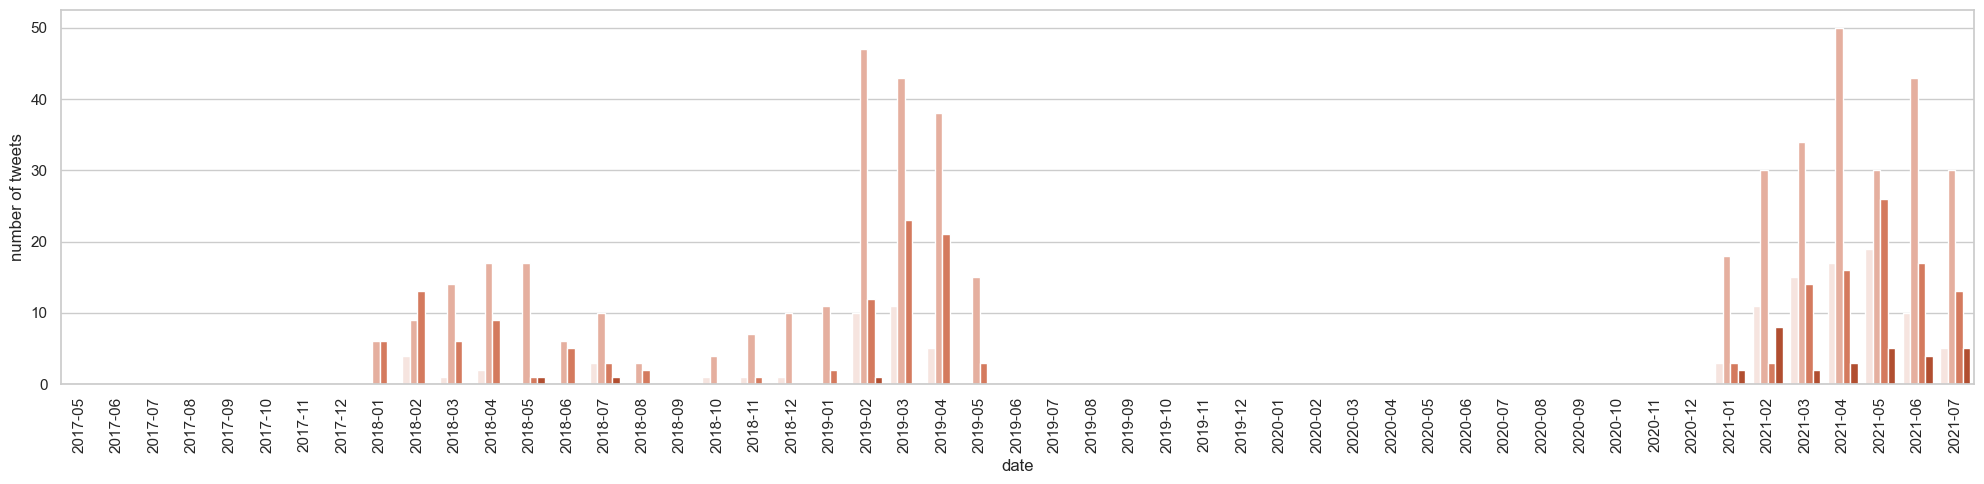

In [141]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="whitegrid")
 
#bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_australia_politicians_stats_party_split, hue = "party", palette = australia_cols)

#bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_australia_politicians_stats_party_split, hue = "party", palette=australia_cols_climate)

bar3 = sns.barplot(x="date",  y="downplaying_tweets", data=full_monthly_aggregated_australia_politicians_stats_party_split, hue = "party", palette=australia_cols_downplaying)


bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)
bar3.set_ylabel("number of tweets")


plt.legend([],[], frameon=False)

plt.tight_layout()

In [142]:
monthly_aggregated_australia_politicians_stats_full = politicians_australia_data.groupby(pd.to_datetime(politicians_australia_data['date']).dt.to_period(freq="M")).agg(
    total_tweets = ("cleaned_text","count"),
    climate_tweets = ("climate_related_pred", "sum"),
    downplaying_tweets = ("downplaying_pred", "sum"),
).reset_index()

monthly_aggregated_australia_politicians_stats_full['climate_ratio'] = monthly_aggregated_australia_politicians_stats_full['climate_tweets'] / monthly_aggregated_australia_politicians_stats_full['total_tweets']


monthly_aggregated_australia_politicians_stats_full.head(6)

,date,total_tweets,climate_tweets,downplaying_tweets,climate_ratio
0,2018-01,3469,56,12.0,0.016143
1,2018-02,7090,70,26.0,0.009873
2,2018-03,6815,72,22.0,0.010565
3,2018-04,6038,92,28.0,0.015237
4,2018-05,6429,88,19.0,0.013688
5,2018-06,3283,44,11.0,0.013402


In [143]:
full_monthly_aggregated_australia_politicians_stats_full = pd.merge(full_date_series,monthly_aggregated_australia_politicians_stats_full,
            on = "date",
            how = "left")

Text(0, 0.5, 'number of tweets')

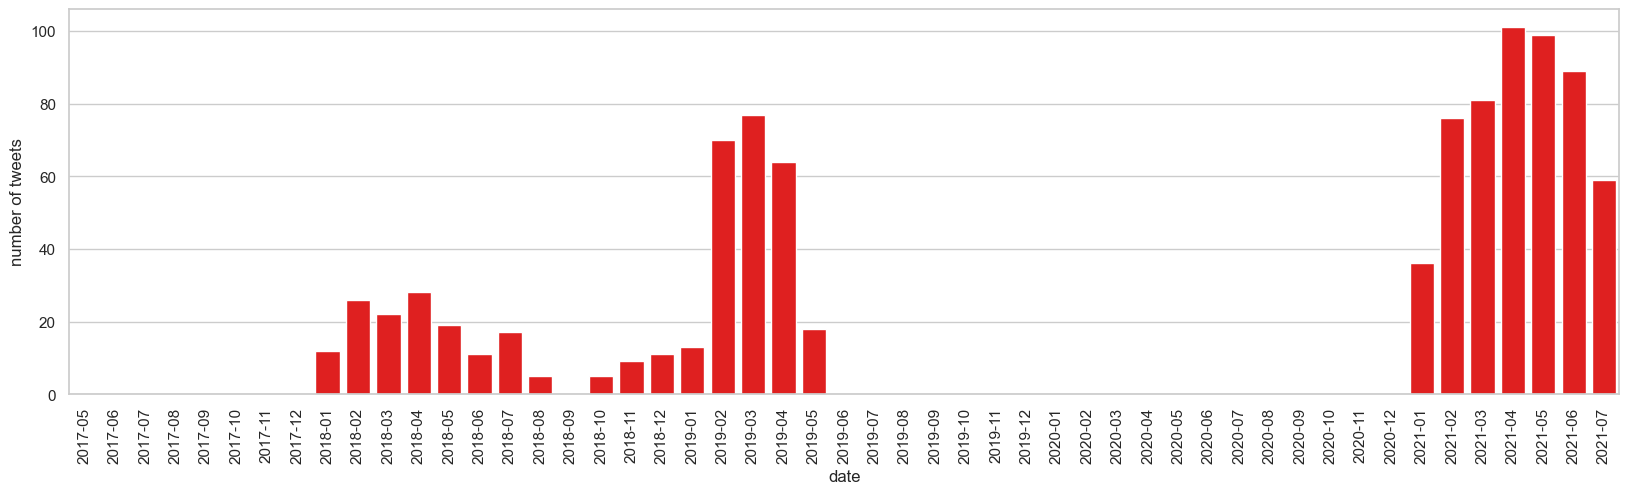

In [144]:
plt.figure(figsize=(20, 5))
#bar1 = sns.barplot(x="date",  y="total_tweets", data=full_monthly_aggregated_australia_politicians_stats_full, color='grey')
#bar2 = sns.barplot(x="date",  y="climate_tweets", data=full_monthly_aggregated_australia_politicians_stats_full, color='green')
bar3 = sns.barplot(x = "date", y= "downplaying_tweets", data=full_monthly_aggregated_australia_politicians_stats_full, color='red')

bar3.set_xticklabels(bar3.get_xticklabels(), rotation=90)

bar3.set_ylabel("number of tweets")


Text(0.5, 1.0, '2021 frequent trigrams Australian Greens')

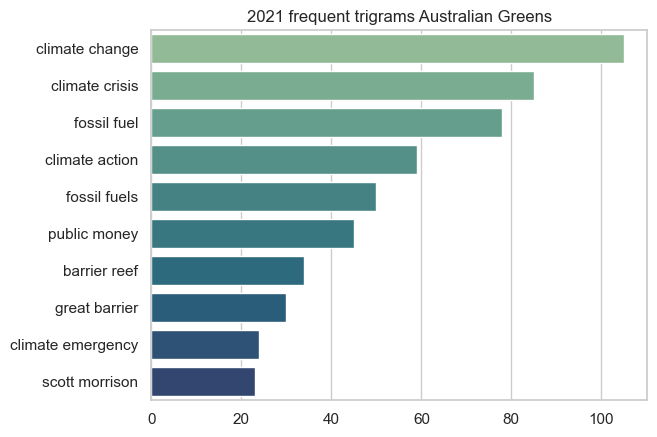

In [145]:
# plot the top n ngrams for each party and each year

year_plot = 2021
party_plot = "Australian Greens"
x,y=map(list,zip(*counter(politicians_australia_data['bigram_text'][(politicians_australia_data['climate_related_pred'] == 1) & 
                                                              (politicians_australia_data['downplaying_pred'] == 0) &
                                                              (politicians_australia_data['year'] == year_plot) &
                                                              (politicians_australia_data['party'] == party_plot)
                                                                            ]).most_common(10)))

# turn the tuples into a combined string
for i in range(len(x)):
    x[i] = ' '.join(x[i])

sns.barplot(x=y,y=x, palette="crest").set_title(str(year_plot) + " frequent trigrams "+ party_plot)

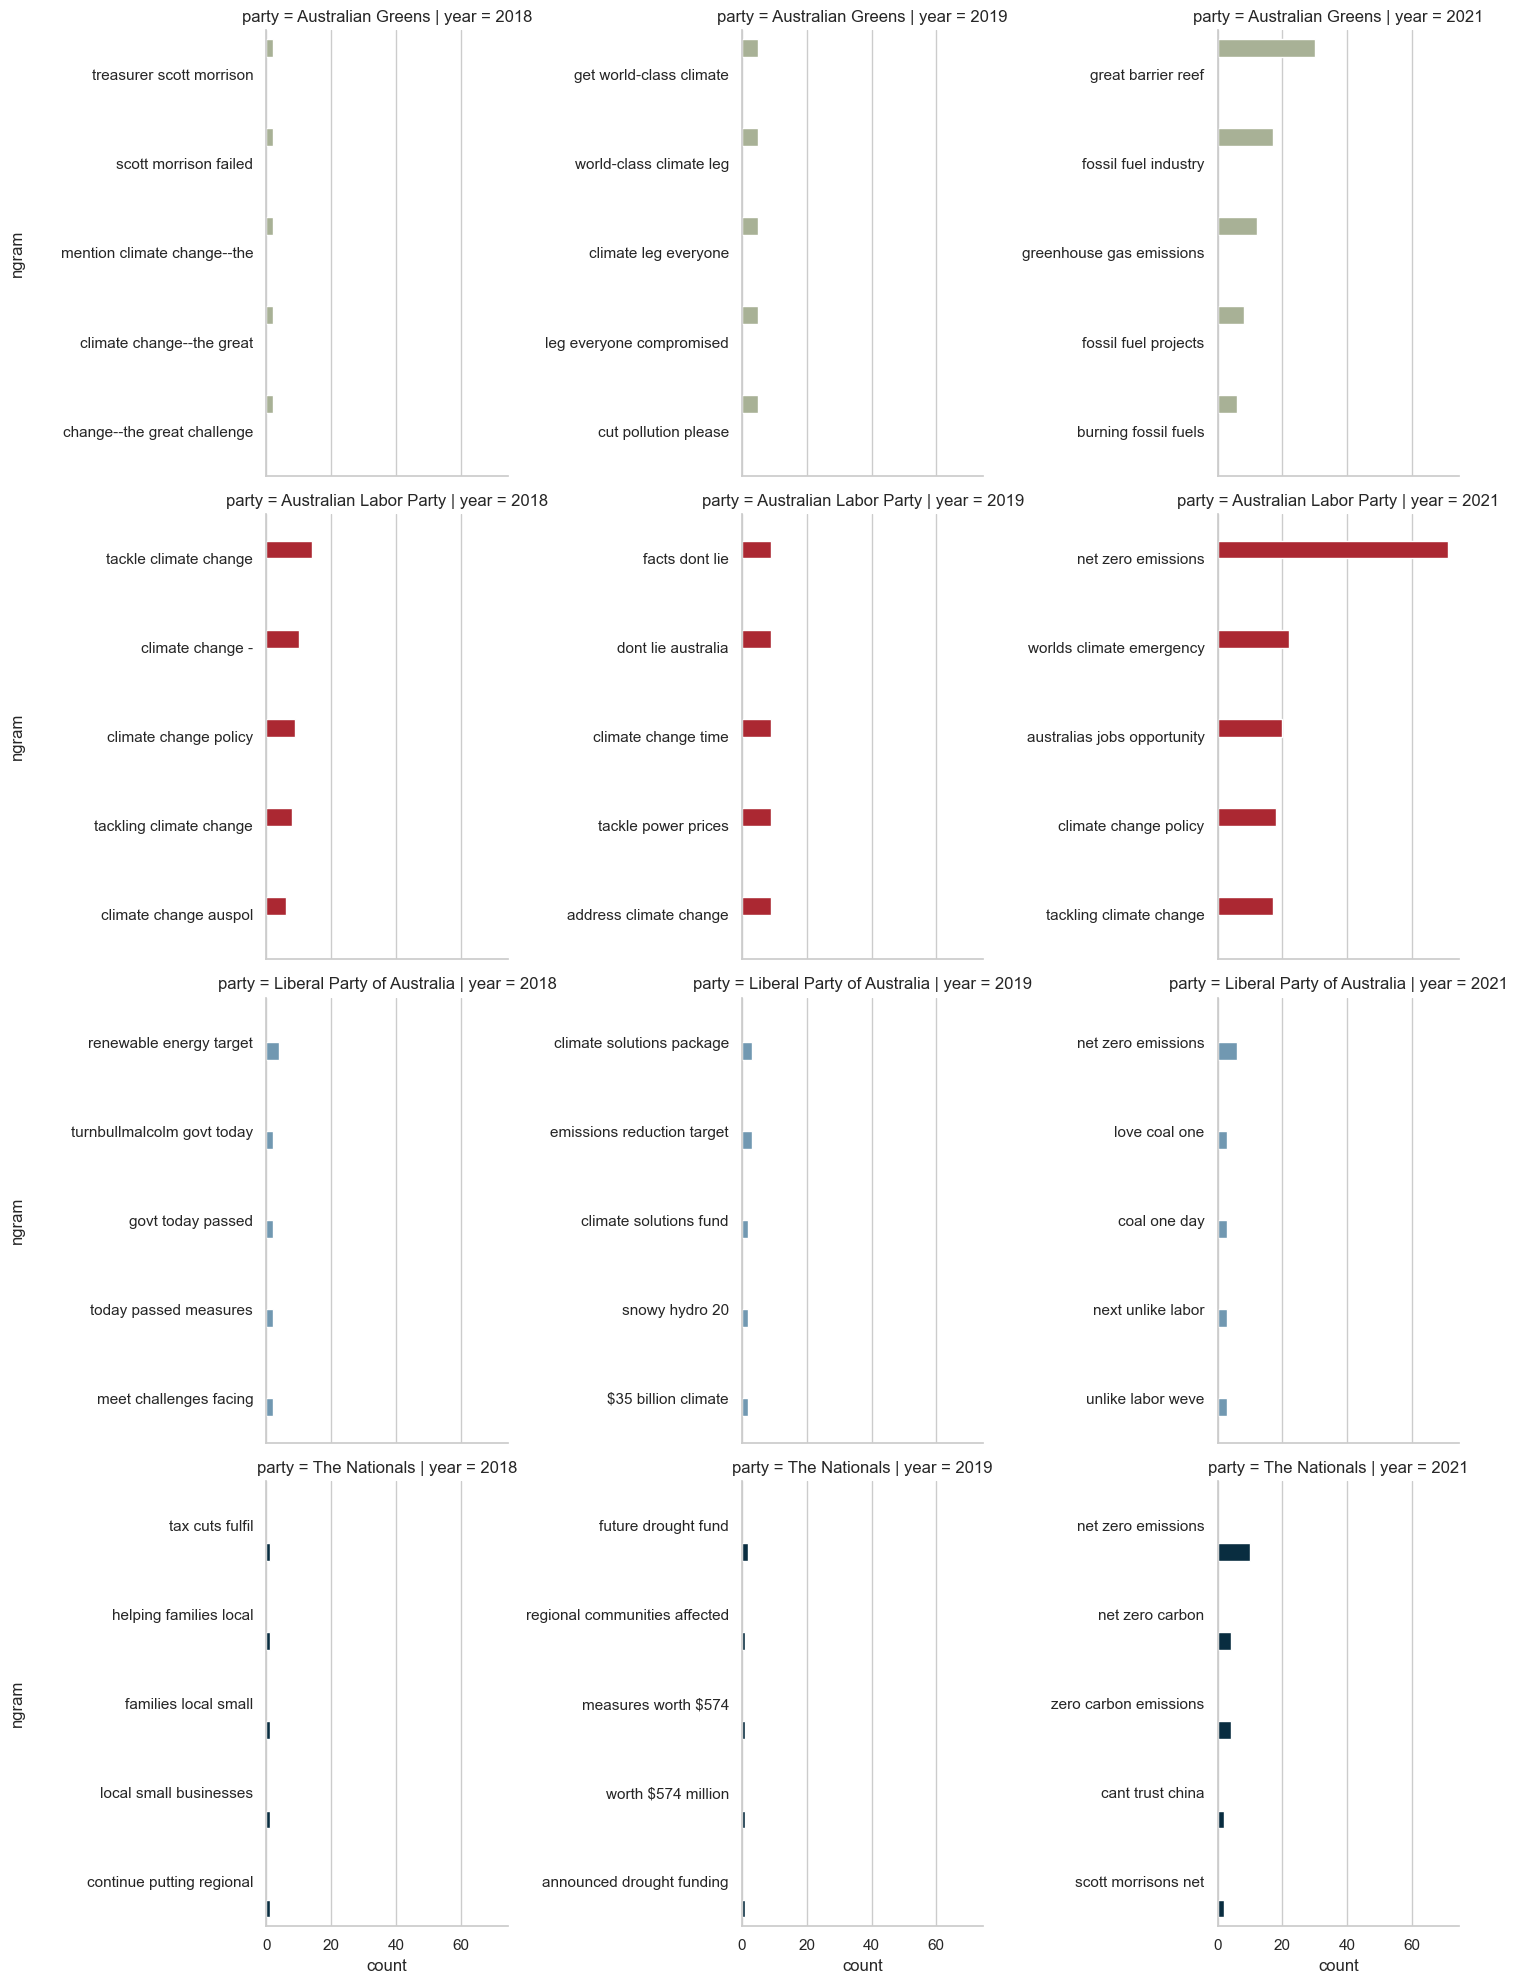

In [146]:
# create list of years and parties to plot
year_plots = [2018, 2019, 2021]
party_plots = ["Australian Greens", 
               "Australian Labor Party",
               "Liberal Party of Australia",
               'The Nationals',
               ]

# create empty list to store results
results = pd.DataFrame()

# loop through years and parties to get bigram frequencies
for year_plot in year_plots:
    for party_plot in party_plots:
        x,y=map(list,zip(*counter(politicians_australia_data['trigram_text'][(politicians_australia_data['climate_related_pred'] == 1) & 
                                                              (politicians_australia_data['downplaying_pred'] == 0) &
                                                              (politicians_australia_data['year'] == year_plot) &
                                                              (politicians_australia_data['party'] == party_plot)
                                                                            ]).most_common(5)))
        
        for i in range(len(x)):
             x[i] = ' '.join(x[i])
        
        temp_df_ngram = pd.DataFrame(x,y).reset_index().rename(columns={"index":"count",0:"ngram"})
        temp_df_ngram['year'] = year_plot
        temp_df_ngram['party'] = party_plot

        # append results to list
        results = pd.concat([results,temp_df_ngram])
        

# create long dataframe
#df = pd.DataFrame(results)

# plot using catplot
g = sns.catplot(
            x='count', 
            y='ngram', 
            col = "year", 
            row = "party", 
            data= results, 
            kind='bar', 
            hue = "party", 
            palette = australia_cols, 
            sharey=False, 
            sharex = True,
        )
        

for ax in g.axes.flatten():
    ax.get_yaxis().set_label_coords(-1,0.5)

plt.tight_layout()

In [147]:
summary_stats_australia_politicians = politicians_australia_data.groupby("name").agg(
    
    party = ('party', lambda x: x.unique()[0]),

    first_tweet = ('date', lambda x: pd.to_datetime(x).min()),

    last_tweet = ('date', lambda x: pd.to_datetime(x).max()),

    total_tweets = ('cleaned_text', 'count'),

    mean_followers = ("followers", lambda x: x.mean().round(1)),

    climate_related =('climate_related_pred', sum),
    
    downplaying=('downplaying_pred', sum),

)

summary_stats_australia_politicians['climate_ratio'] = summary_stats_australia_politicians['climate_related'] / summary_stats_australia_politicians['total_tweets']
summary_stats_australia_politicians['downplaying_ratio'] = summary_stats_australia_politicians['downplaying'] / summary_stats_australia_politicians['climate_related']
summary_stats_australia_politicians['downplaying_ratio'] = summary_stats_australia_politicians['downplaying_ratio'].fillna(0)

summary_stats_australia_politicians['net_proclim_twt_rate_hemmi'] = ((summary_stats_australia_politicians['climate_related']-summary_stats_australia_politicians['downplaying'])-summary_stats_australia_politicians['downplaying'])/summary_stats_australia_politicians['total_tweets']


summary_stats_australia_politicians['underscoring_ratio'] = 1 - summary_stats_australia_politicians['downplaying_ratio']

summary_stats_australia_politicians.reset_index(inplace=True)

In [148]:
filtered_summary_stats_australia_politicians = summary_stats_australia_politicians[summary_stats_australia_politicians['party'].isin(["Australian Labor Party",
                                                                                                                                      "Liberal Party of Australia",
                                                                                                                                      "The Nationals",
                                                                                                                                      "Australian Greens"])]

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


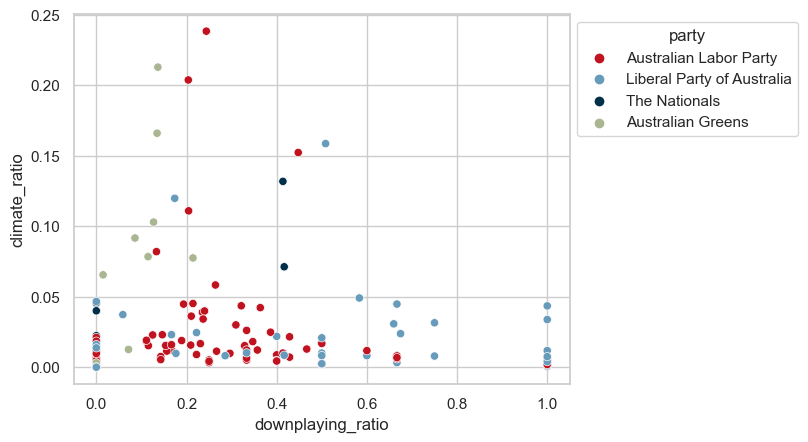

In [149]:
#sns.set_theme("whitegrid")

plot = sns.scatterplot(data = filtered_summary_stats_australia_politicians,
                x = "downplaying_ratio",
                y = "climate_ratio" ,
                hue = "party",
                palette= australia_cols
                )

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

c:\Users\lucas\anaconda3\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


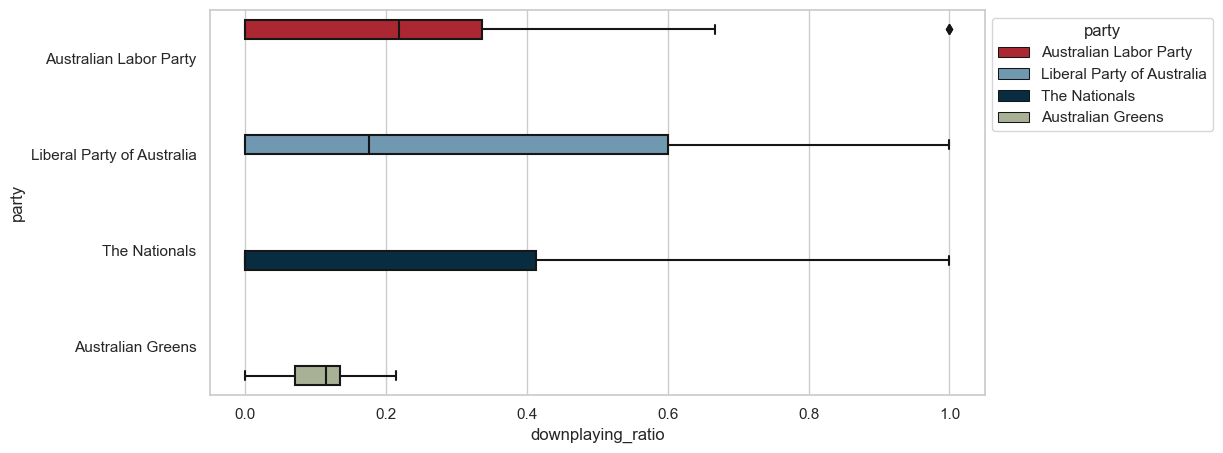

In [150]:
plt.figure(figsize=(10,5))

plot = sns.boxplot(data = filtered_summary_stats_australia_politicians,
                x = "downplaying_ratio",
                y = "party" ,
                hue = "party",
                palette=australia_cols
                )

sns.move_legend(plot,
    "upper left", bbox_to_anchor=(1, 1)
)

In [151]:
len(filtered_summary_stats_australia_politicians.name.unique())

163

Text(0.5, 1.1, "Results Australian politicians' tweets")

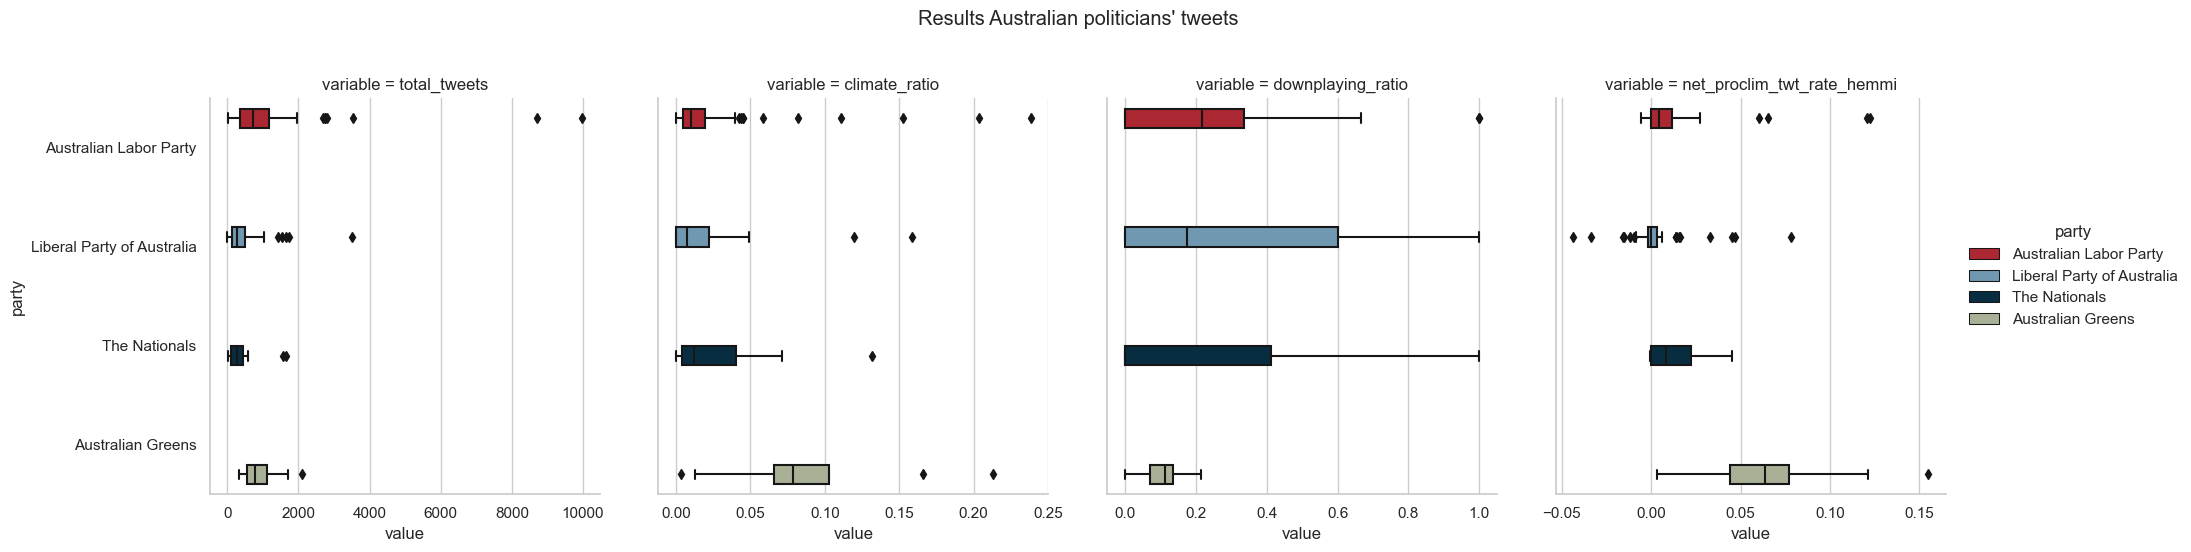

In [152]:
sns.set_style("whitegrid")

g = sns.catplot(
            x='value', 
            y='party', 
            col = "variable", 
            #row = "party", 
            data= filtered_summary_stats_australia_politicians[["party","name","total_tweets","climate_ratio","downplaying_ratio", "net_proclim_twt_rate_hemmi"]].melt(id_vars=["party","name"]), 
            kind="box", 
            hue = "party", 
            palette = australia_cols, 
            sharey=True, 
            sharex = False,
        )

plt.subplots_adjust(wspace=0.15)

plt.suptitle("Results Australian politicians' tweets", y=1.1)
#g.fig.suptitle('ONE TITLE FOR ALL')

#plt.tight_layout()

In [153]:
filtered_summary_stats_australia_politicians[["party","name","total_tweets","climate_ratio","downplaying_ratio","net_proclim_twt_rate_hemmi"]].groupby("party").agg(
    n_politicians = ("name", "count"),
    mean_total_tweet = ("total_tweets", lambda x: round(np.mean(x),2)),
    mean_climate_ratio = ("climate_ratio", lambda x: round(np.mean(x),2)),
    mean_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.mean(x),2)),
    mean_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.mean(x),2)),
    
    median_total_tweet = ("total_tweets", lambda x: round(np.median(x),2)),
    median_climate_ratio = ("climate_ratio", lambda x: round(np.median(x),2)),
    median_downplaying_ratio = ("downplaying_ratio", lambda x: round(np.median(x),2)),
    median_proclimate_twt_rate = ("net_proclim_twt_rate_hemmi", lambda x: round(np.median(x),2)),
)

,n_politicians,mean_total_tweet,mean_climate_ratio,mean_downplaying_ratio,mean_proclimate_twt_rate,median_total_tweet,median_climate_ratio,median_downplaying_ratio,median_proclimate_twt_rate
party,,,,,,,,,
Australian Greens,9,953.33,0.09,0.10,0.07,778.0,0.08,0.11,0.06
Australian Labor Party,84,1069.33,0.02,0.24,0.01,711.5,0.01,0.22,0.00
Liberal Party of Australia,57,464.46,0.02,0.33,0.00,260.0,0.01,0.18,0.00
The Nationals,13,458.62,0.03,0.19,0.01,283.0,0.01,0.00,0.01


In [154]:
filtered_summary_stats_australia_politicians.to_csv("./panel_regression/australia_politicians_data.csv", sep = ";")